# Get Data 

In [1]:
import pandas as pd
import math 

data_type = 'word'

training1 = pd.read_csv('data/r_512/r_'+data_type+'_1_final.csv')
training2 = pd.read_csv('data/r_512/r_'+data_type+'_2_final.csv')
training3 = pd.read_csv('data/r_512/r_'+data_type+'_3_final.csv')
test = pd.read_csv('data/r_512/r_'+data_type+'_4_final.csv')

In [2]:
df = [training1,training2, training3]
training = pd.concat(df, ignore_index=True)
training.dropna(inplace = True) 
training.reset_index(inplace = True, drop = True)

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Right Jaw 
plt.plot('CH_1_mV', data = training)
plt.show()

<Figure size 640x480 with 1 Axes>

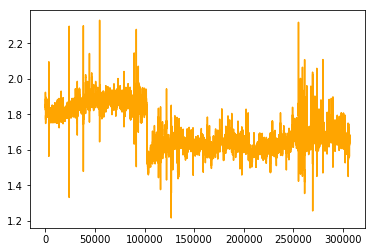

In [4]:
# Left Cheeck
plt.plot('CH_2_mV', data= training,  color='orange')
plt.show()

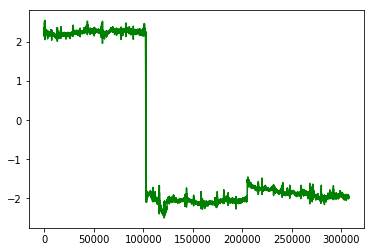

In [5]:
# Throat
plt.plot('CH_3_mV', data= training,  color='green')
plt.show()

# Clean Data 

In [6]:
def low_pass(fc, b):
    '''
    :param fc: cutoff frequency
    :param b: bandwidth
    :return: low pass filter
    '''
    N = int(np.ceil((4 / b)))
    if not N % 2: N += 1
    n = np.arange(N)

    sinc_func = np.sinc(2 * fc * (n - (N - 1) / 2.))
    window = 0.42 - 0.5 * np.cos(2 * np.pi * n / (N - 1)) + 0.08 * np.cos(4 * np.pi * n / (N - 1))
    sinc_func = sinc_func * window
    sinc_func = sinc_func / np.sum(sinc_func)
    return sinc_func

# look up time-domain vs frequency domain relationship 

In [7]:
import numpy as np

# Create new database after filtering data 

def filtered_data(fc,bw, data):
    lp_filter = low_pass(fc,bw)
    cln= {'CH_1_mV': np.convolve(data['CH_1_mV'], lp_filter),
          'CH_2_mV': np.convolve(data['CH_2_mV'], lp_filter),
          'CH_3_mV': np.convolve(data['CH_3_mV'], lp_filter)}
    output = pd.DataFrame(cln)
    diff = len(output)- len(data)
    del_rows = diff/2
    ouput = output.loc[del_rows:len(output)-del_rows-1]
    output.reset_index(inplace = True, drop = True)
    output['Target'] = data['Target']
    return output

def round_up_to_even(f):
    return math.ceil(f / 2.) * 2

new_training =filtered_data(0.02,0.08,training)
new_test = filtered_data(0.02, 0.08, test)

In [8]:
# deterime value ranges for targets 
import more_itertools as mit

def min_max(data, val ='targets'):
    if val == 'targets':
         values = data[data['Target'] != 'relax'].index.tolist()
    else:
         values = data[data['Target'] == 'relax'].index.tolist()
    groups = [list(group) for group in mit.consecutive_groups(values)]
    return groups

groups_targets = min_max(new_training,'targets')
groups_non = min_max(new_training,val = 'non')
groups = groups_targets

# Visualize filtered data

In [9]:
 def create_plots(rows,data):
    '''
    :param rows: rows from ranges of taget values 
    :param data: data frame to use
    :return: plot of sigals
    '''
    plt.figure(figsize=(25,5))

    plt.subplot(1,4,1)
    plt.plot(data['CH_1_mV'][min(rows):max(rows)])

    plt.subplot(1,4,2)
    plt.plot(data['CH_2_mV'][min(rows):max(rows)])

    plt.subplot(1,4,3)
    plt.plot(data['CH_3_mV'][min(rows):max(rows)])
   
    plt.subplot(1,4,4)
    plt.text(0.35, 0.5, data.iloc[min(rows) + 10]['Target'] , dict(size=25))
    
    plt.show()

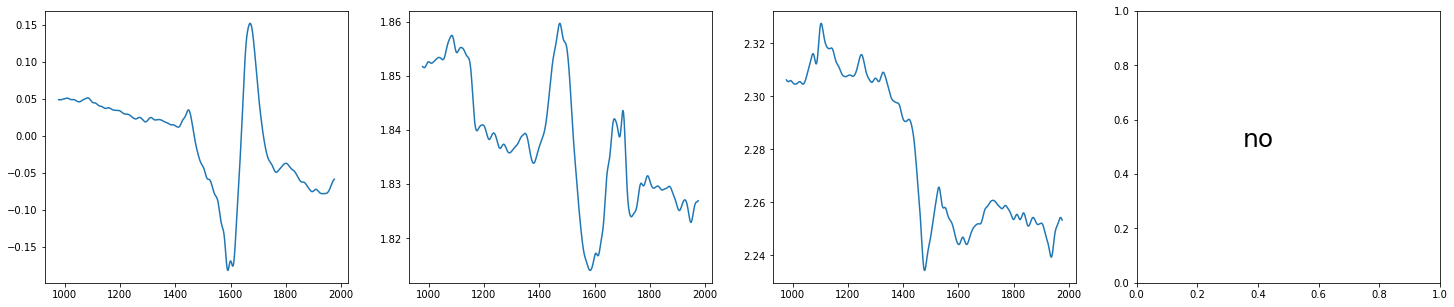

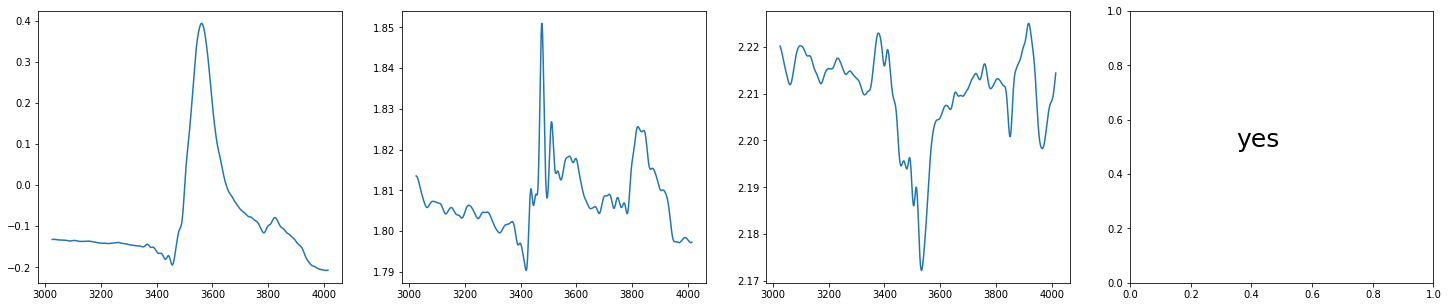

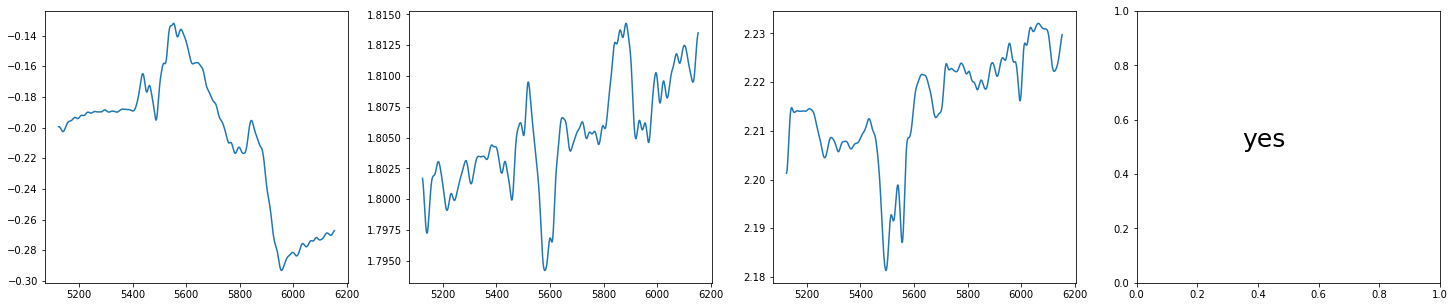

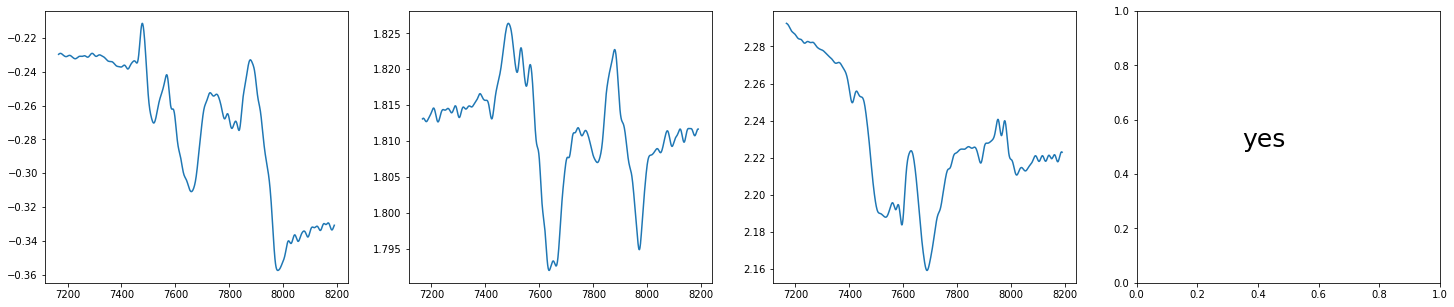

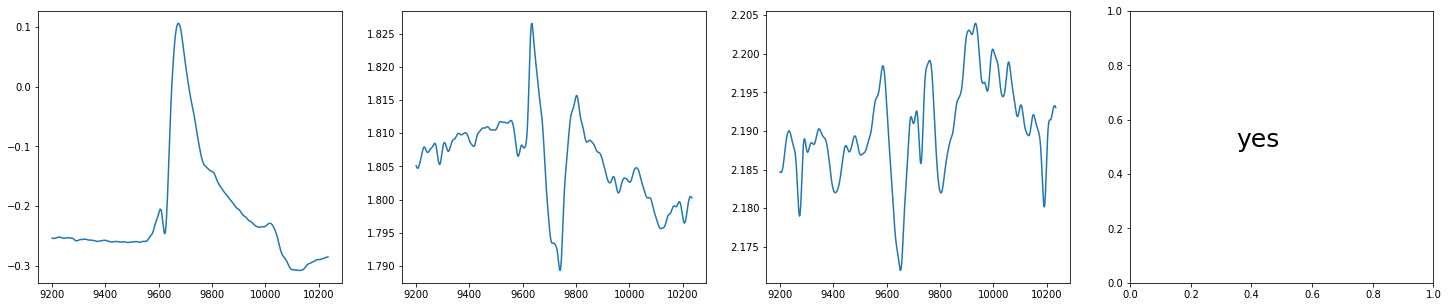

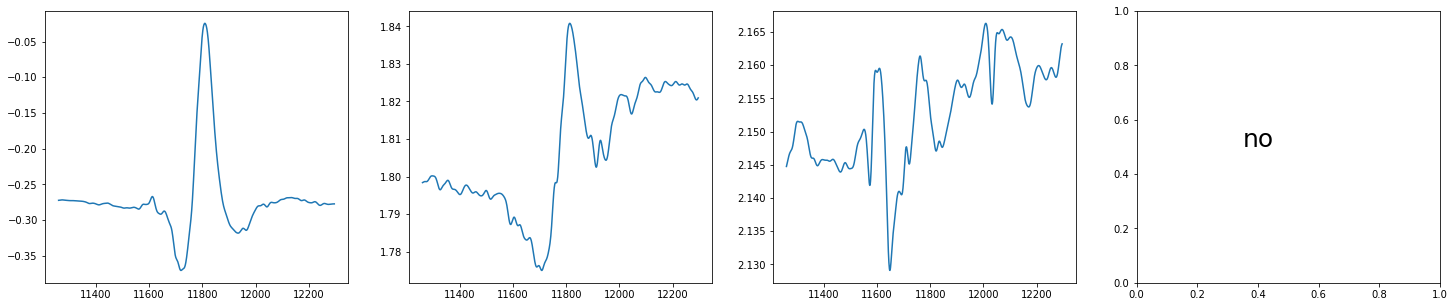

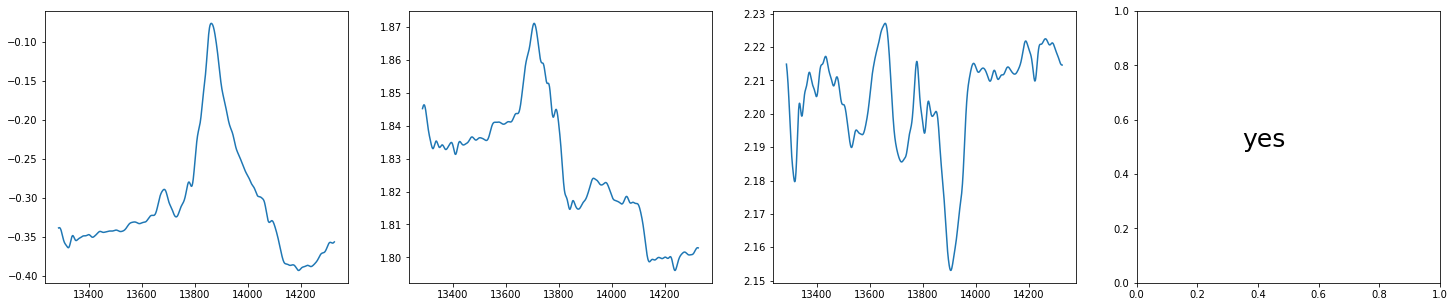

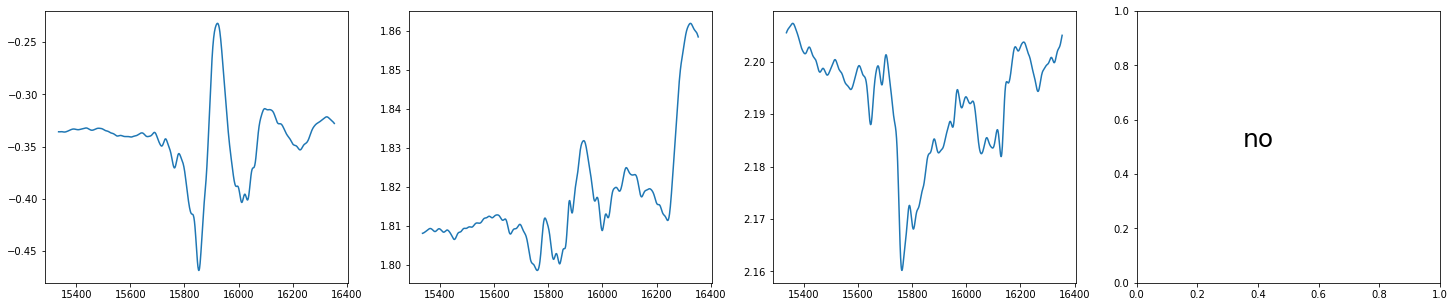

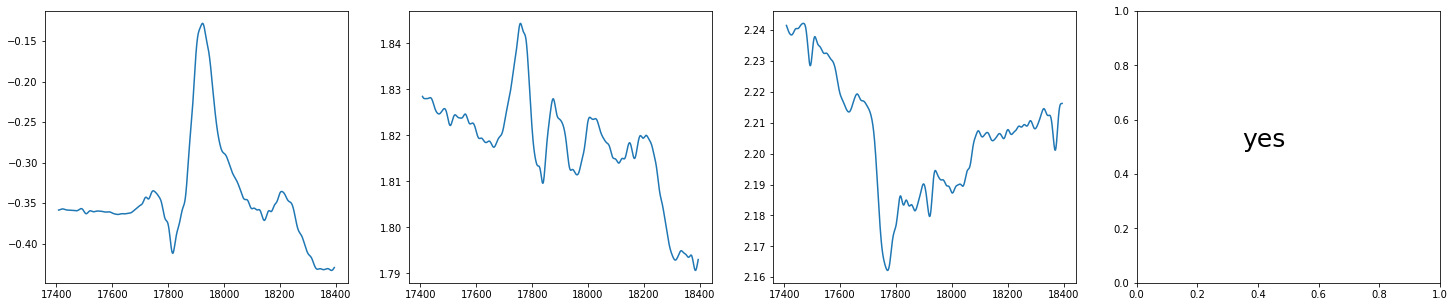

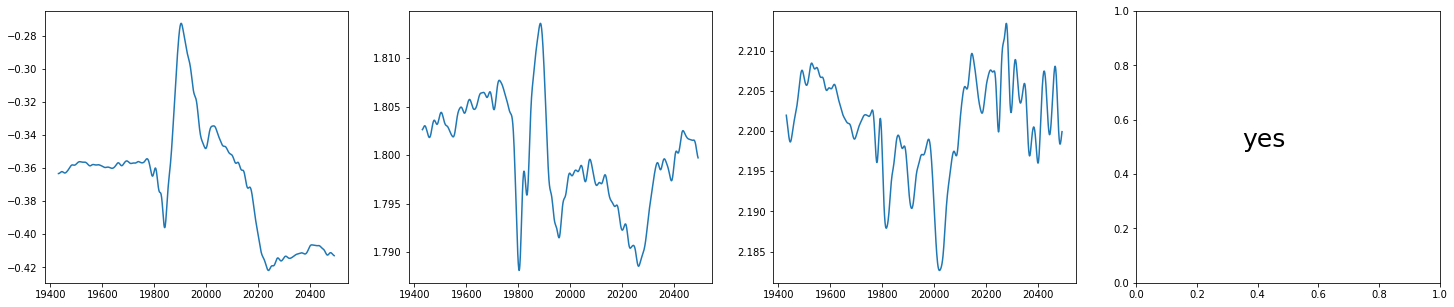

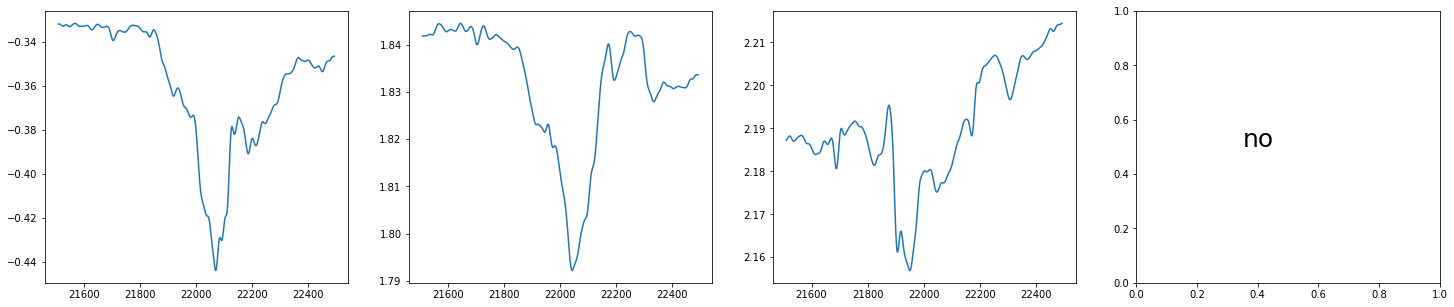

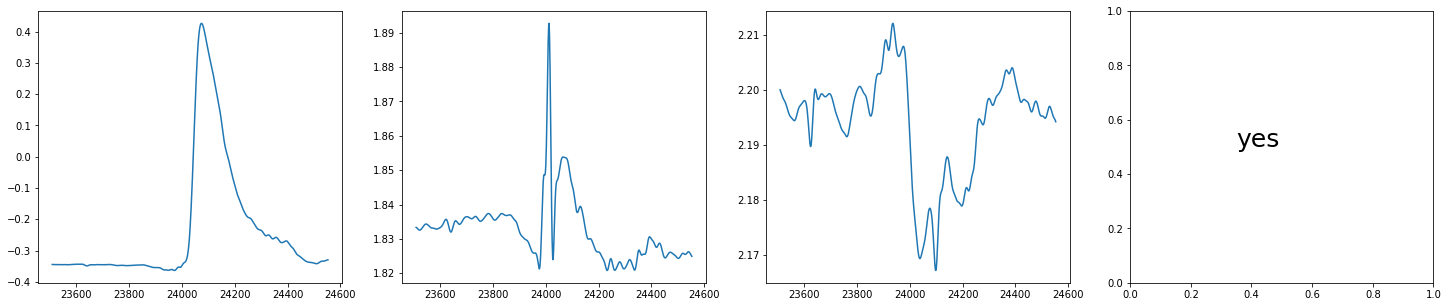

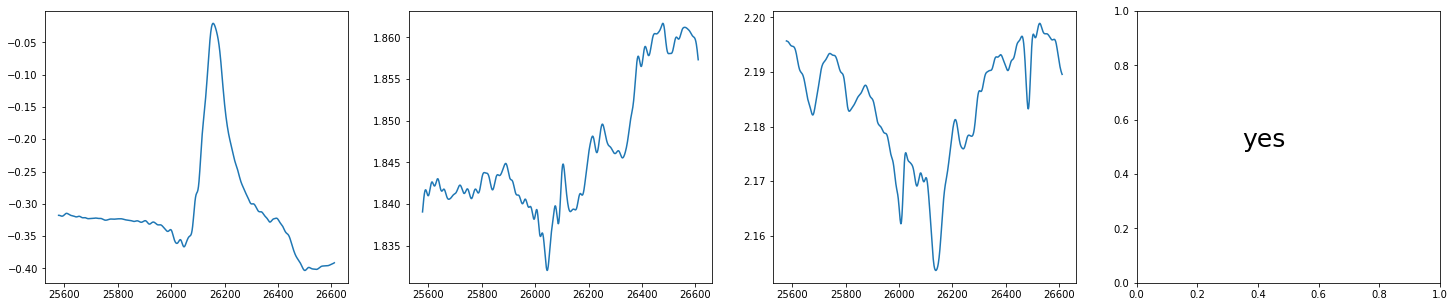

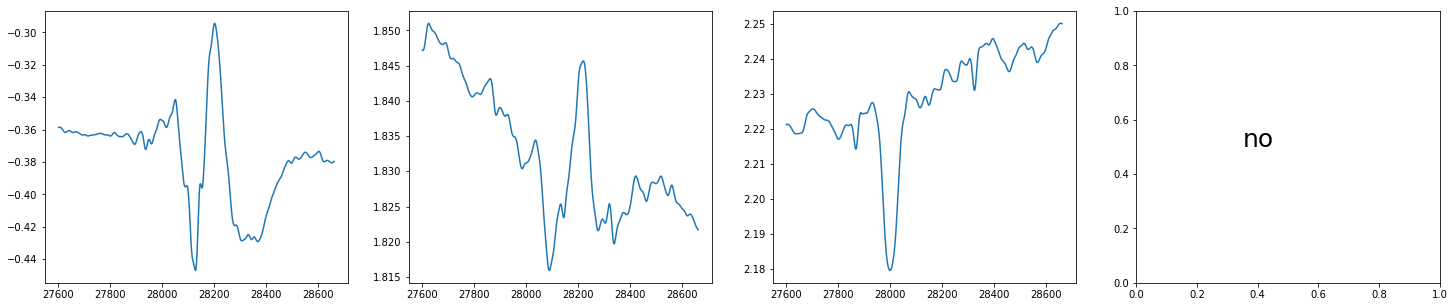

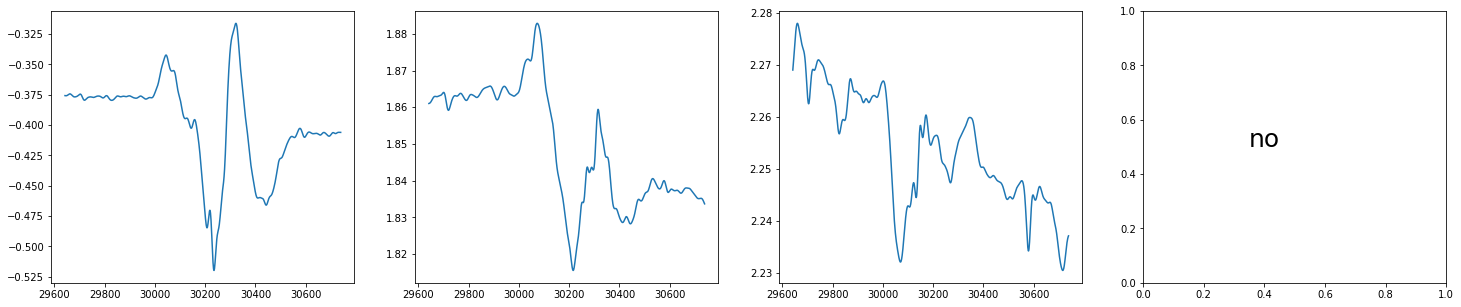

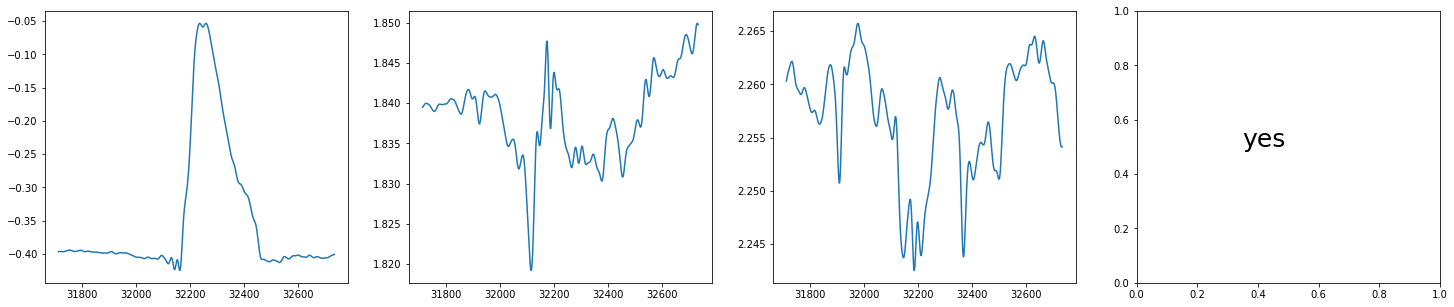

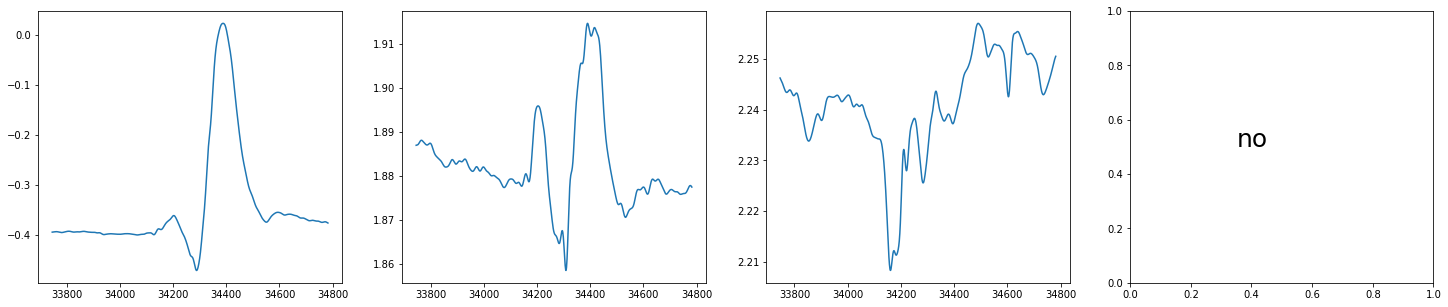

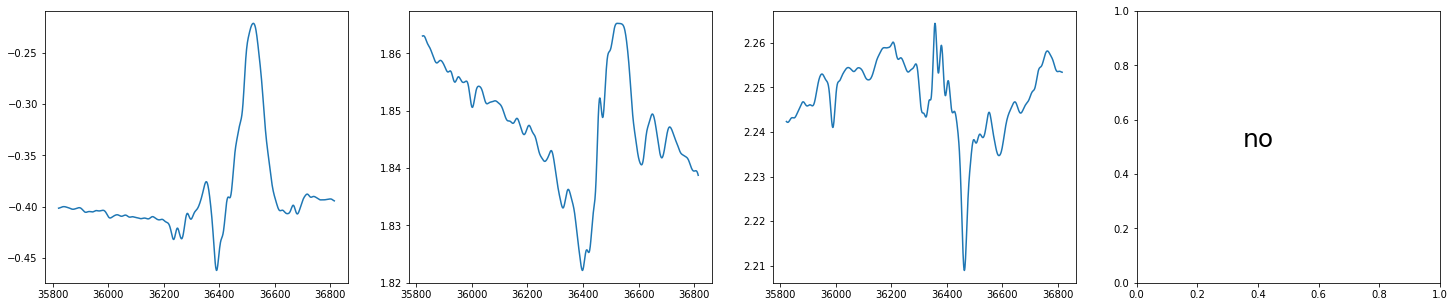

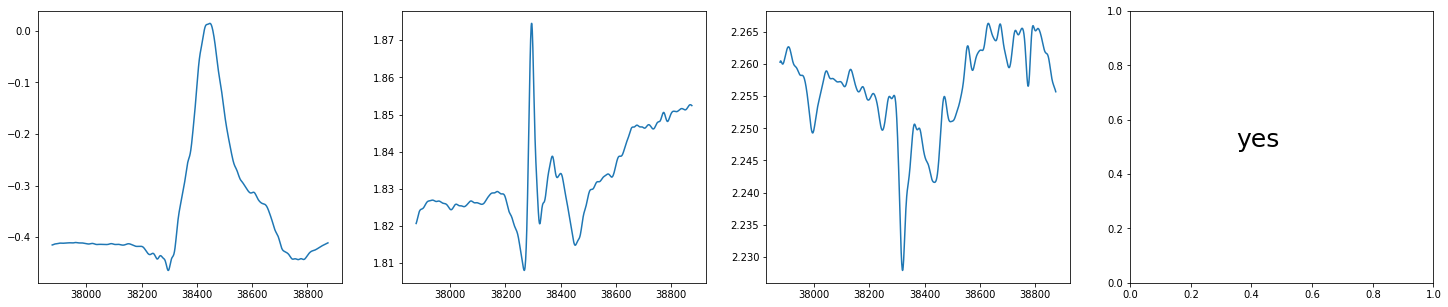

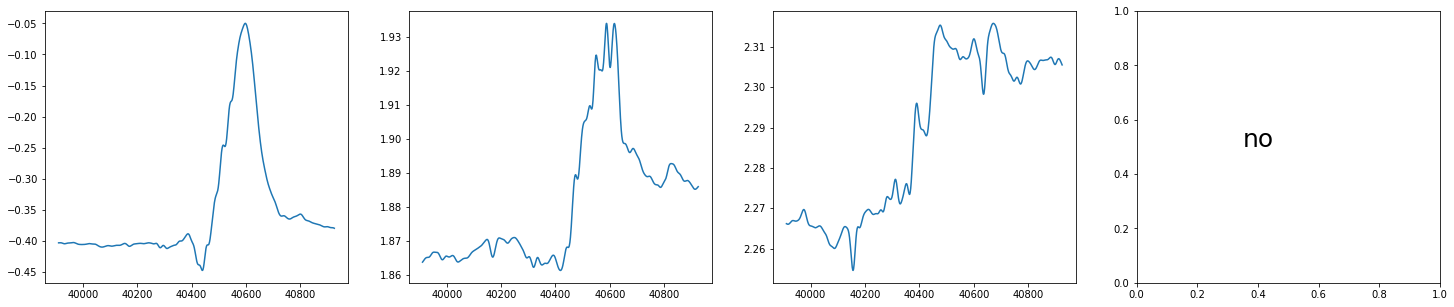

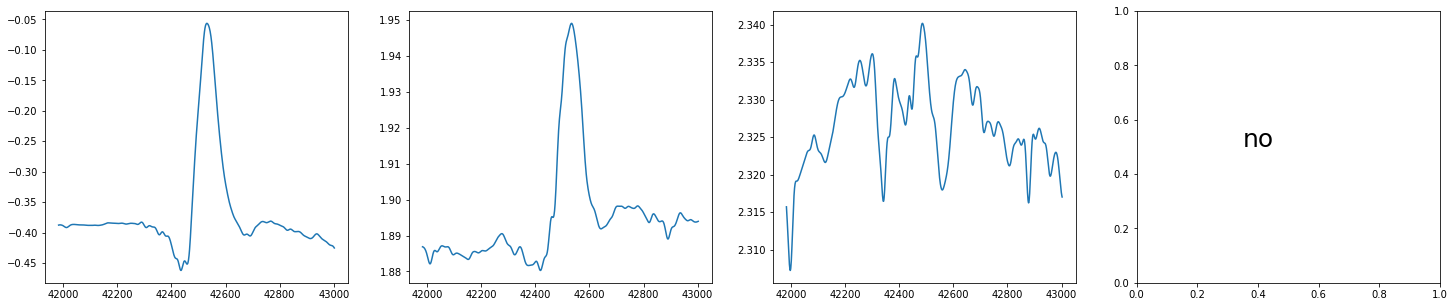

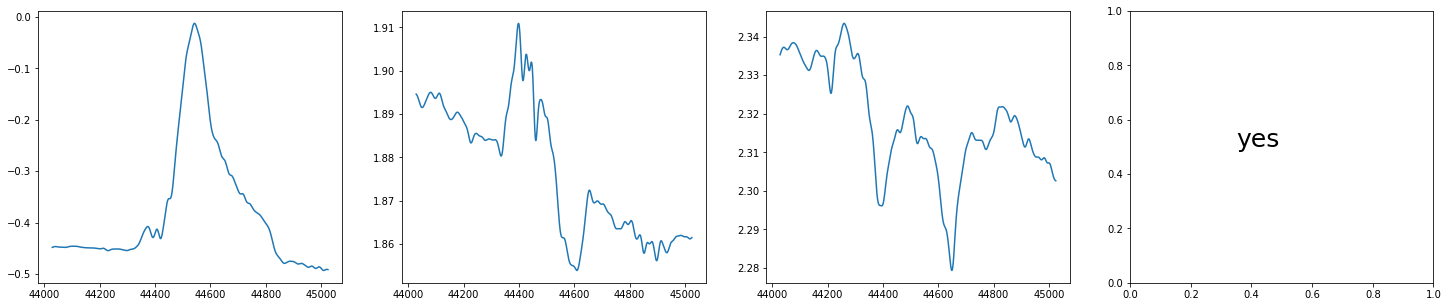

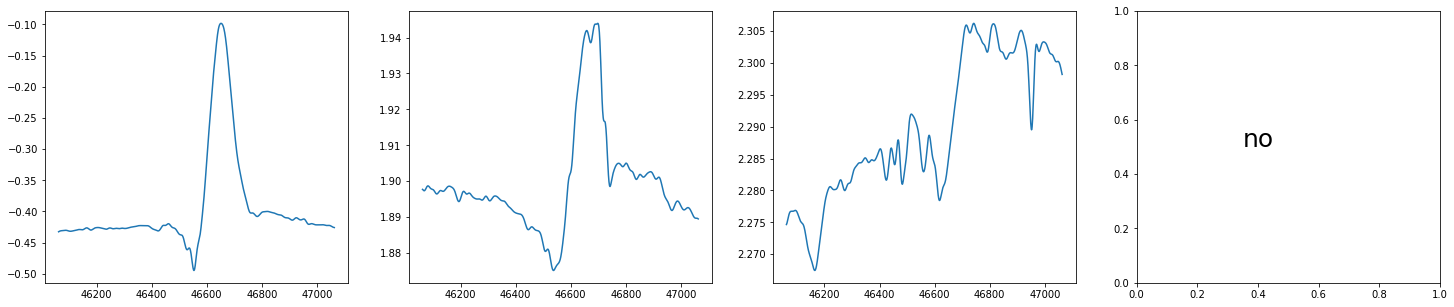

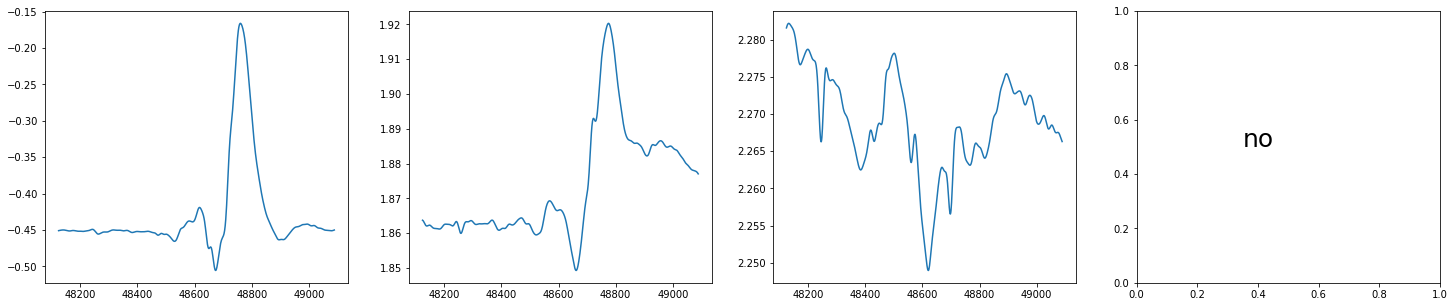

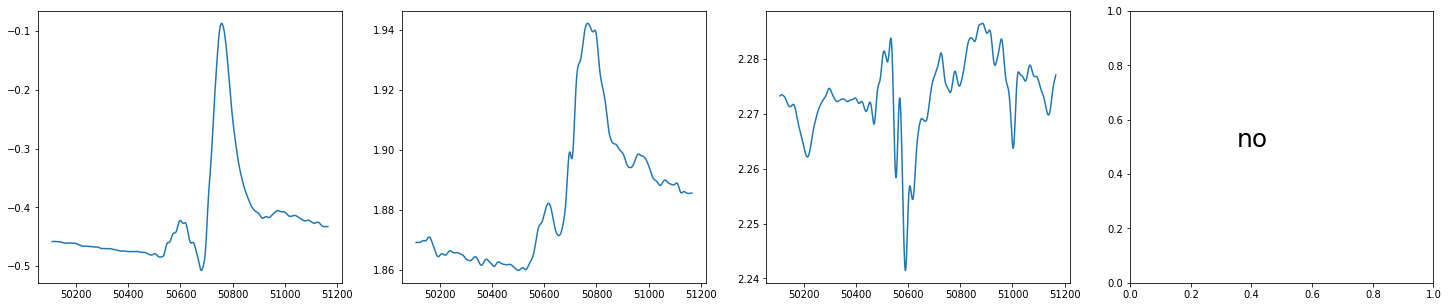

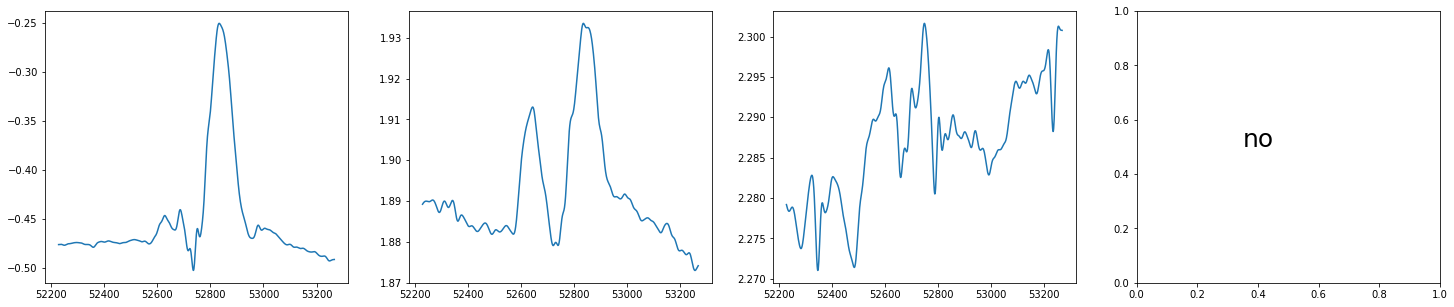

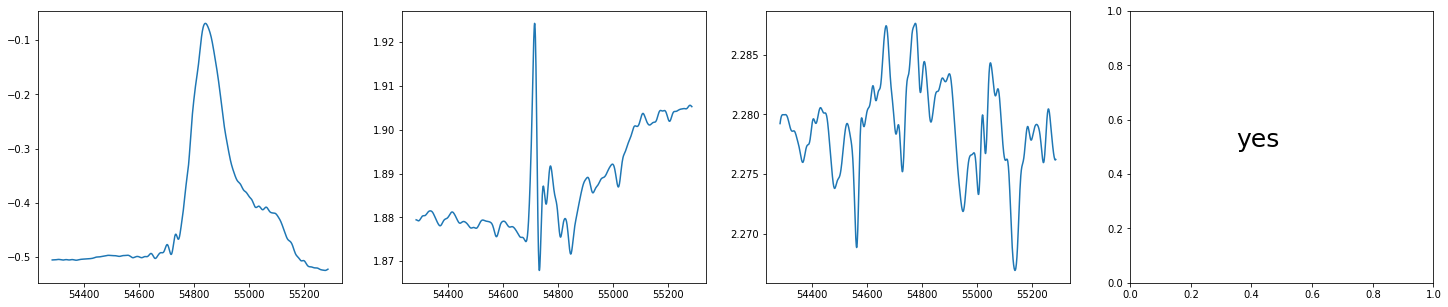

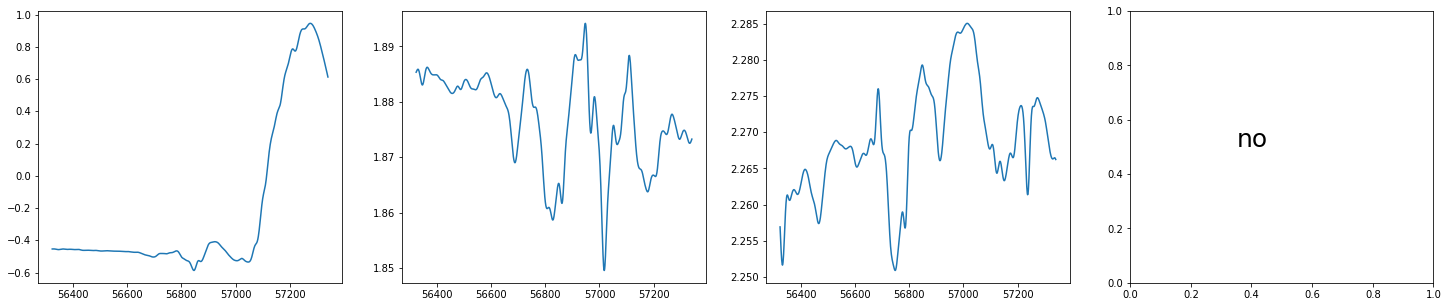

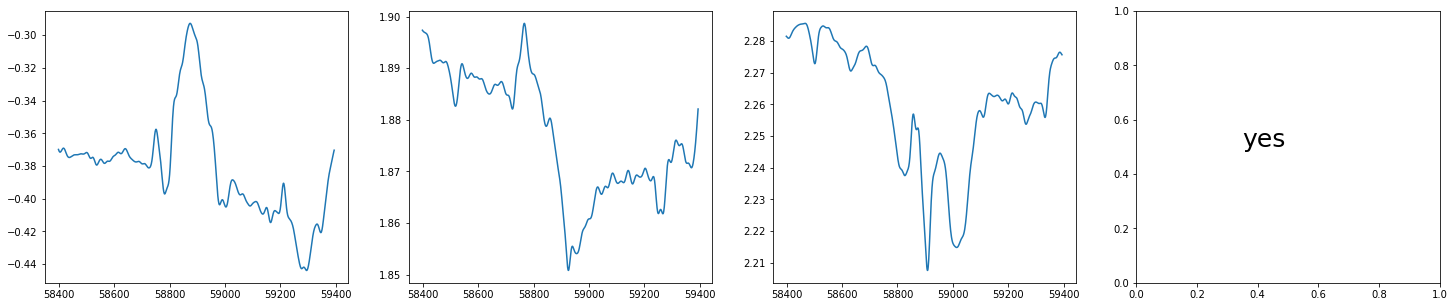

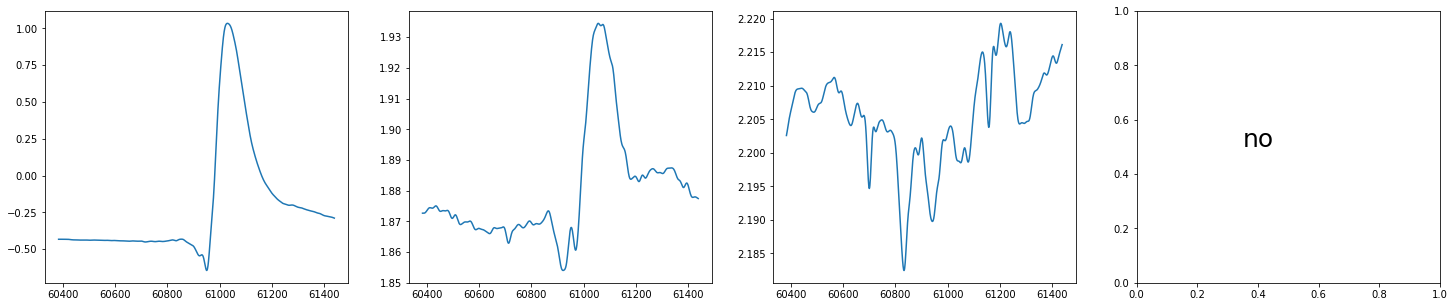

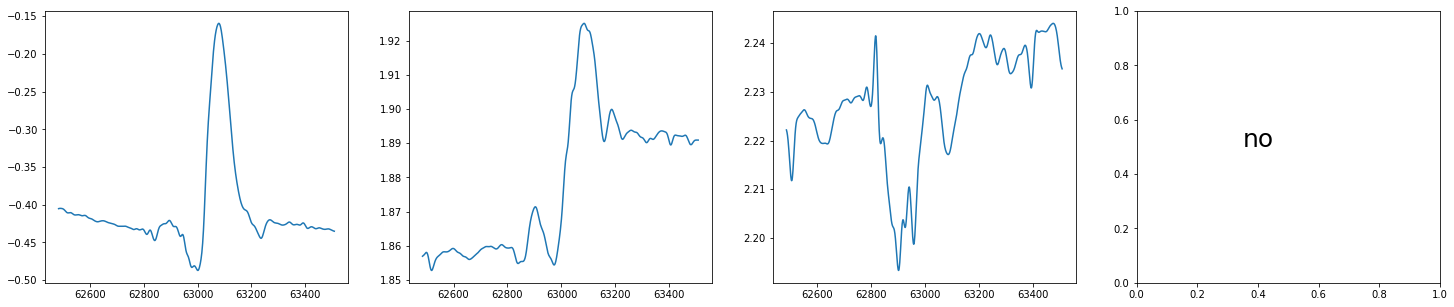

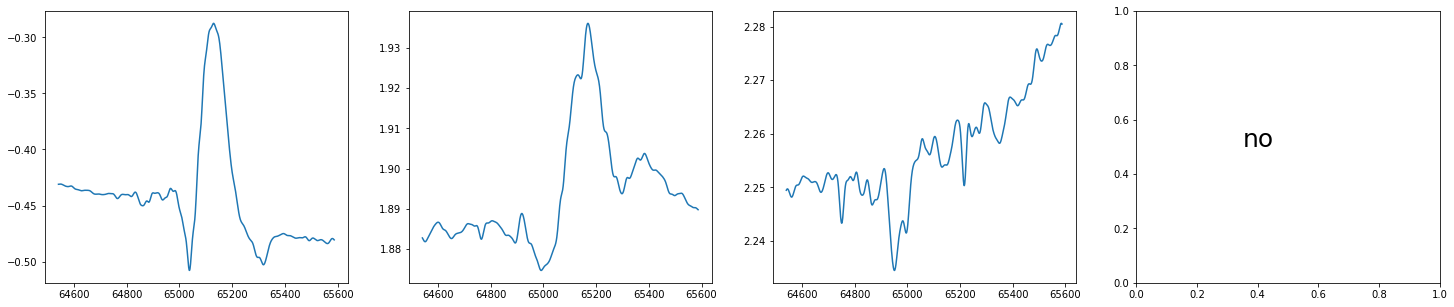

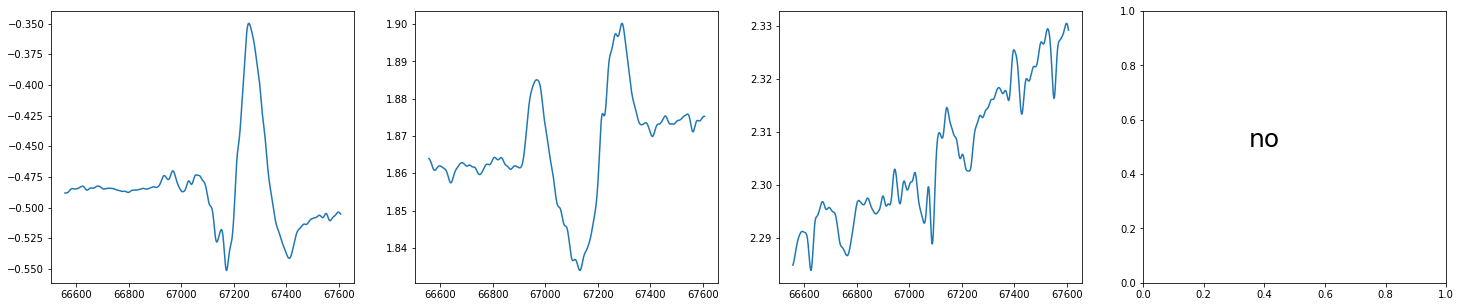

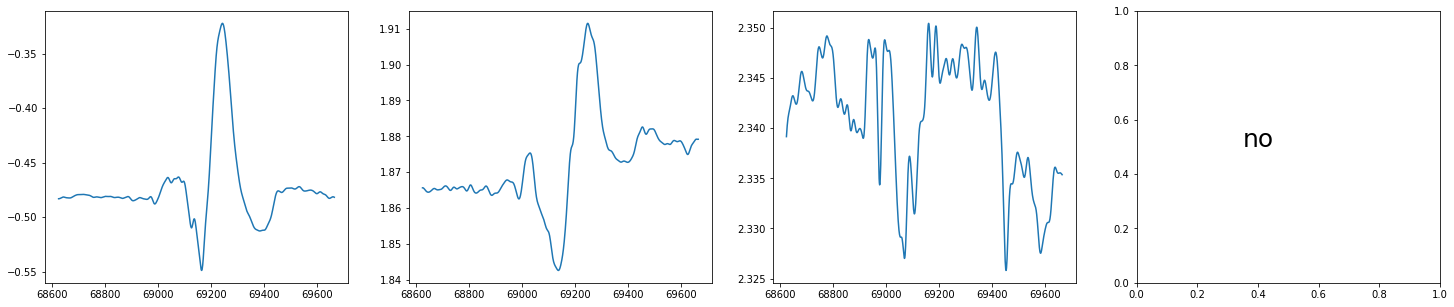

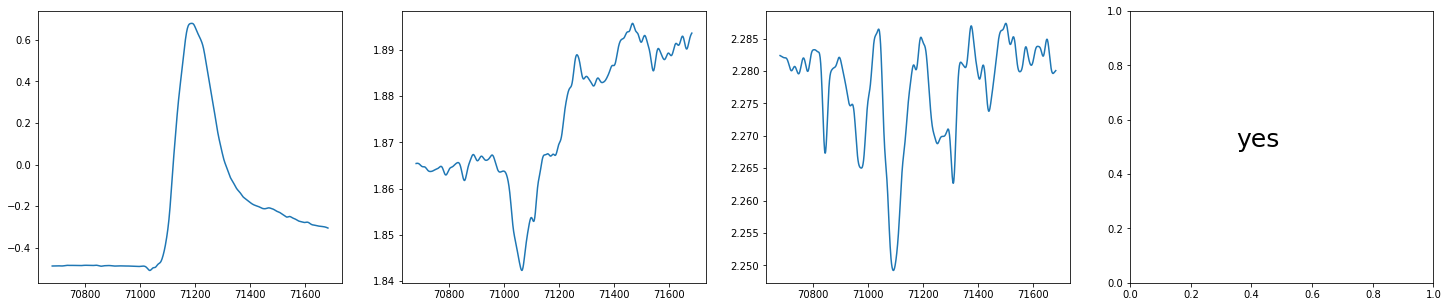

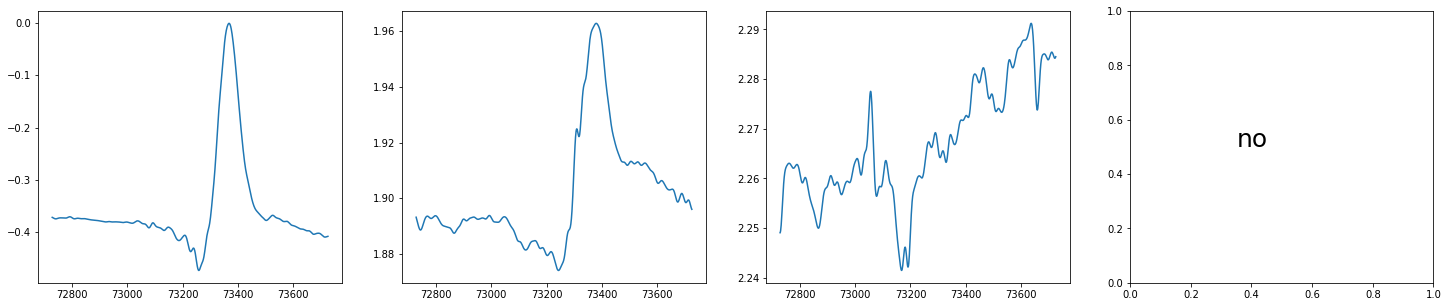

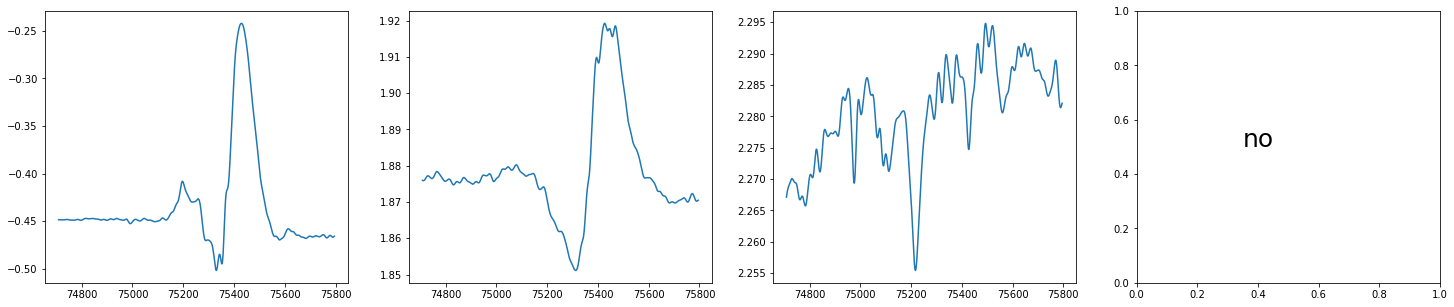

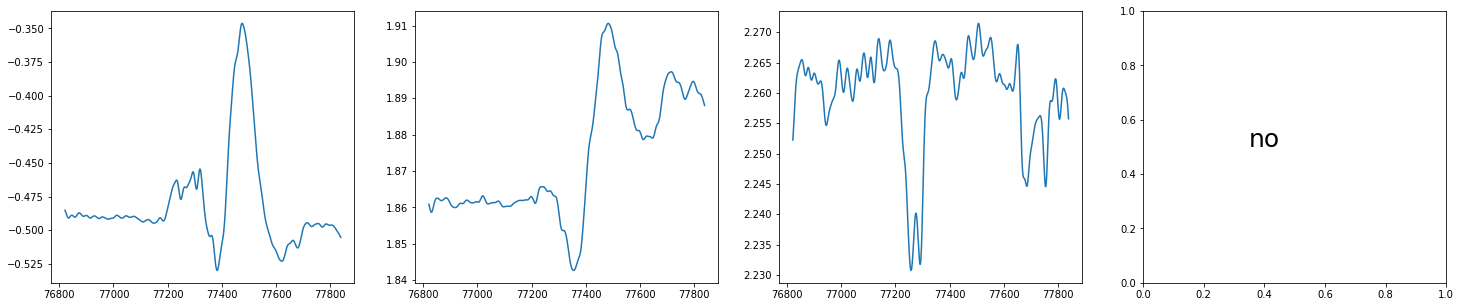

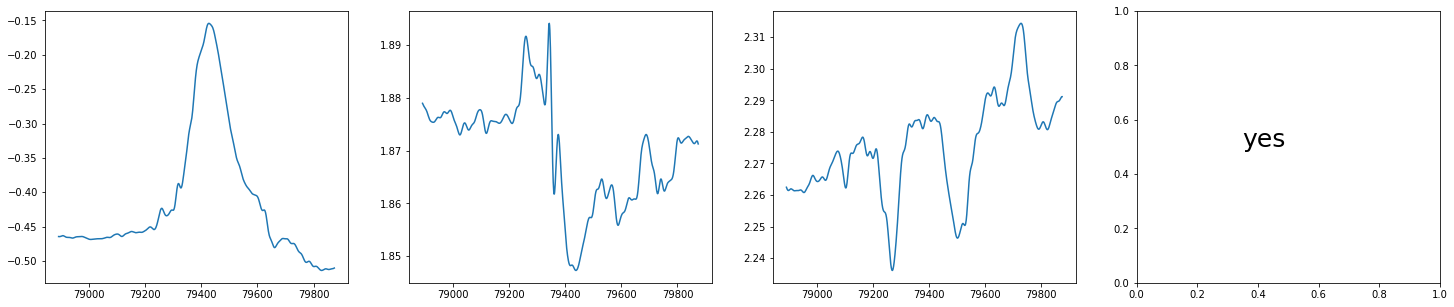

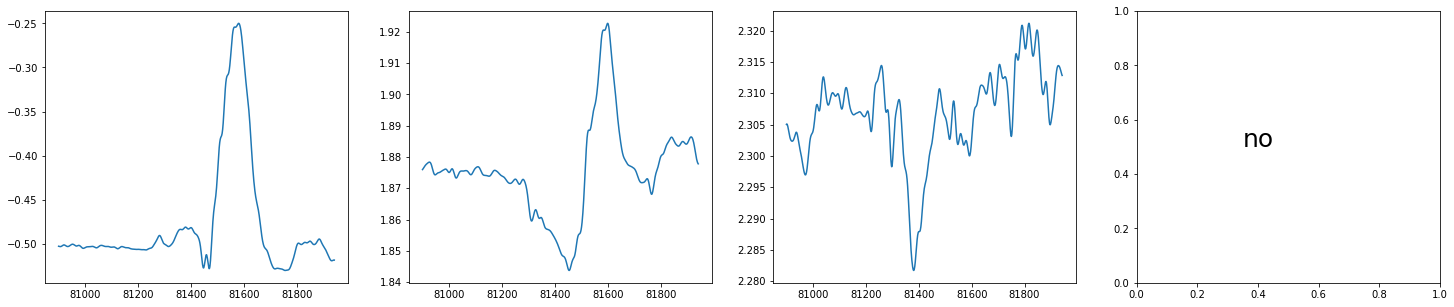

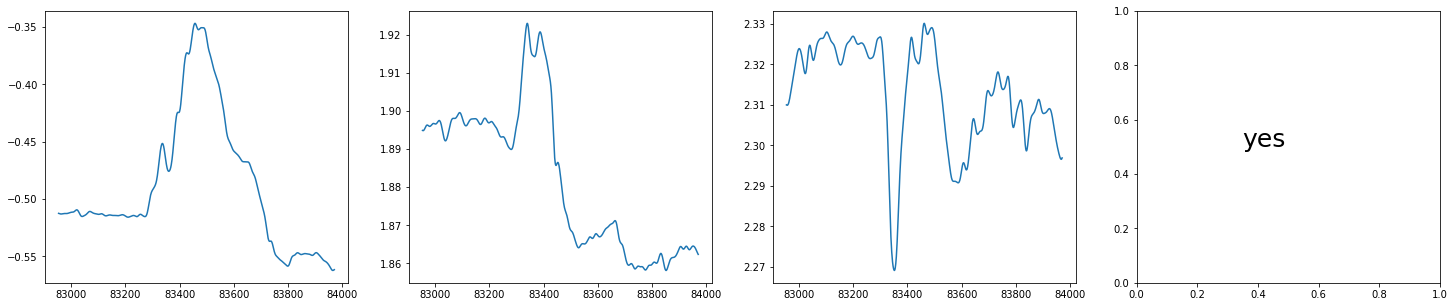

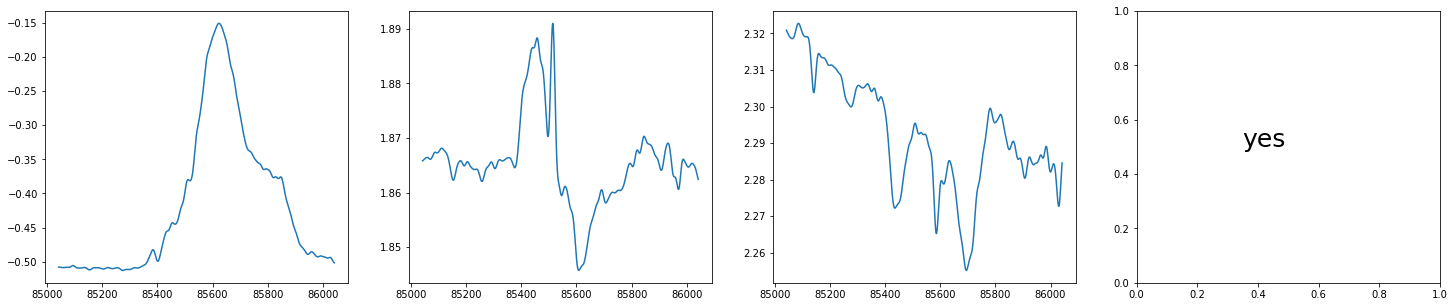

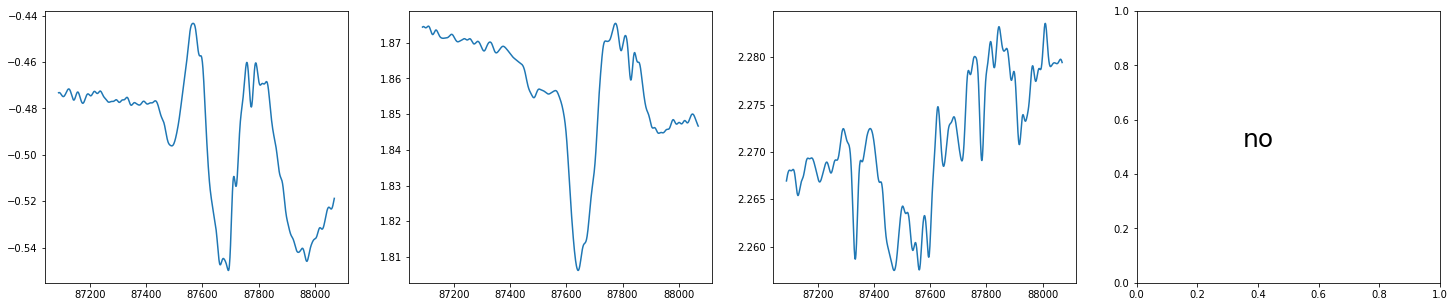

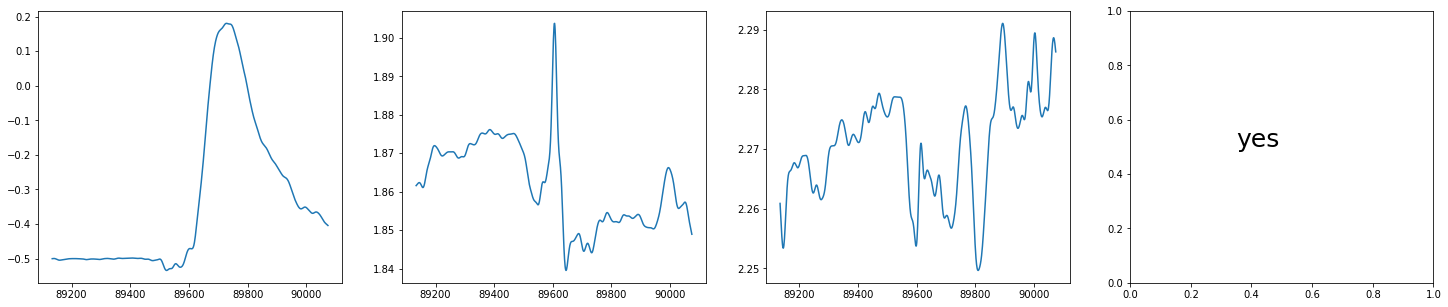

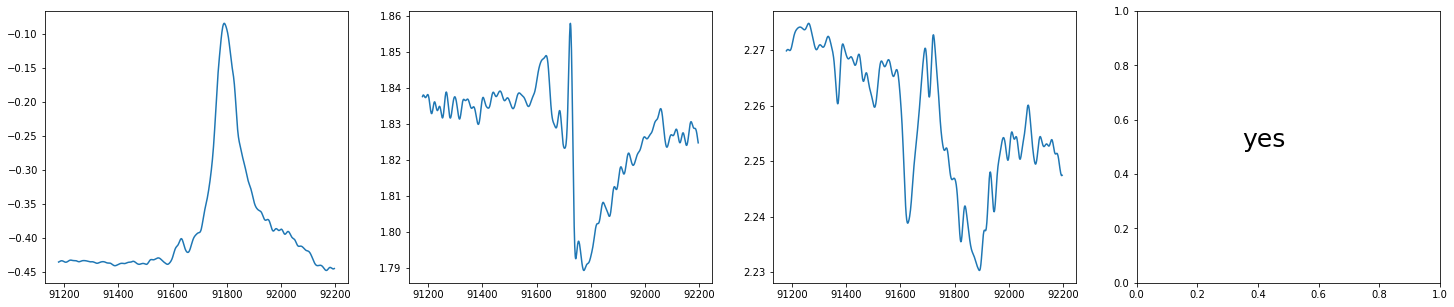

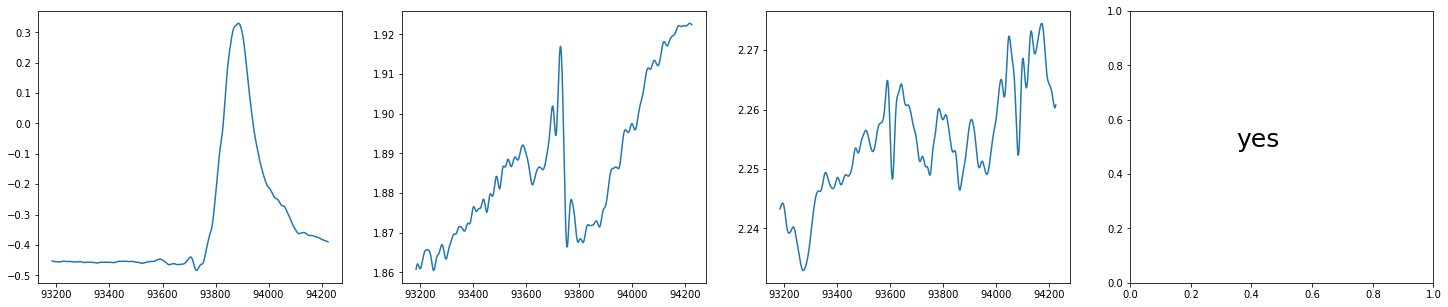

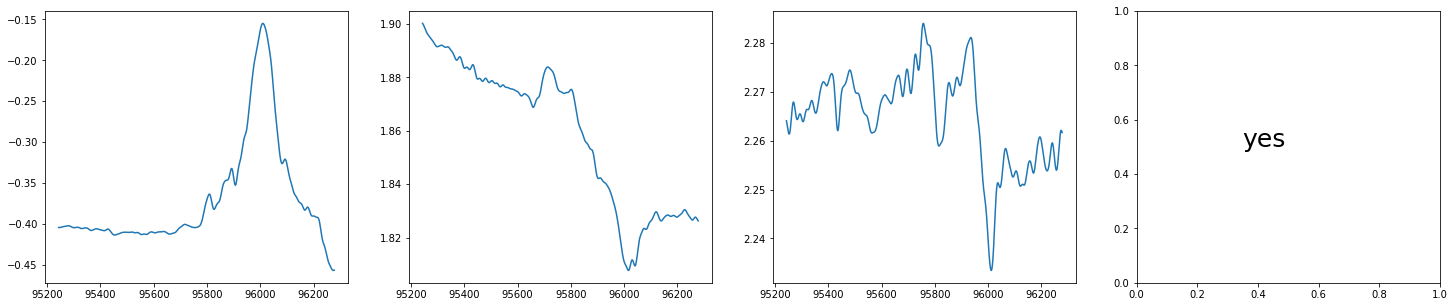

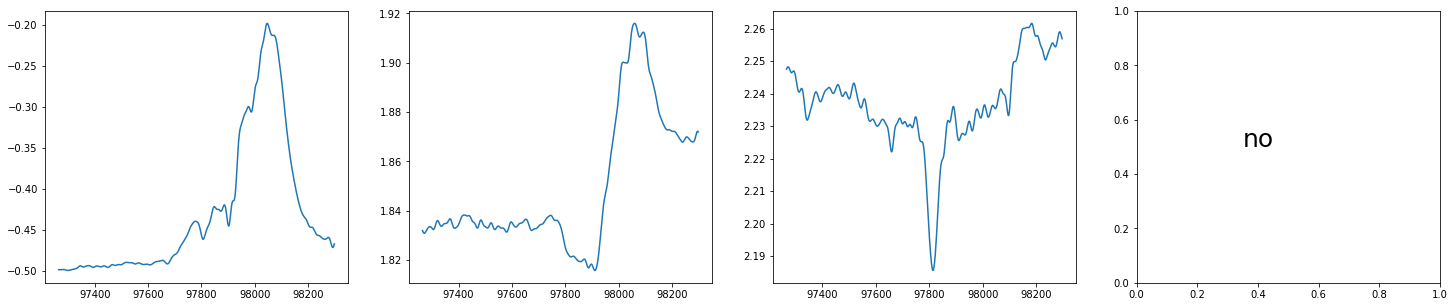

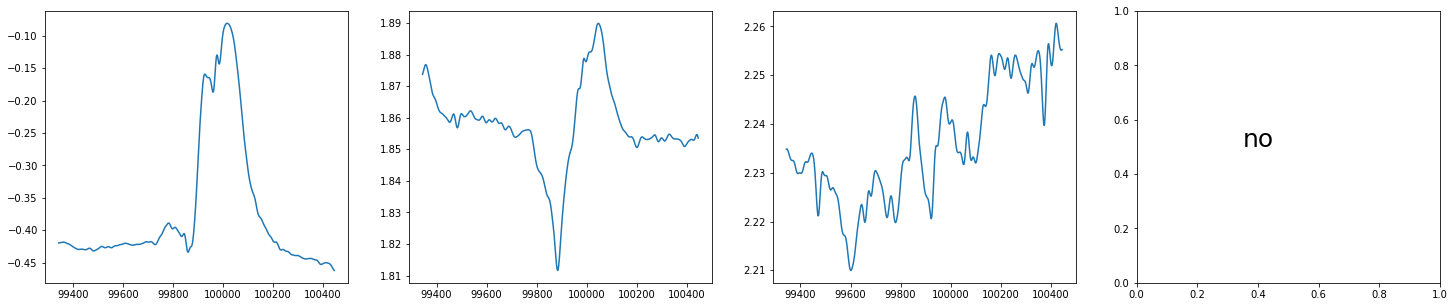

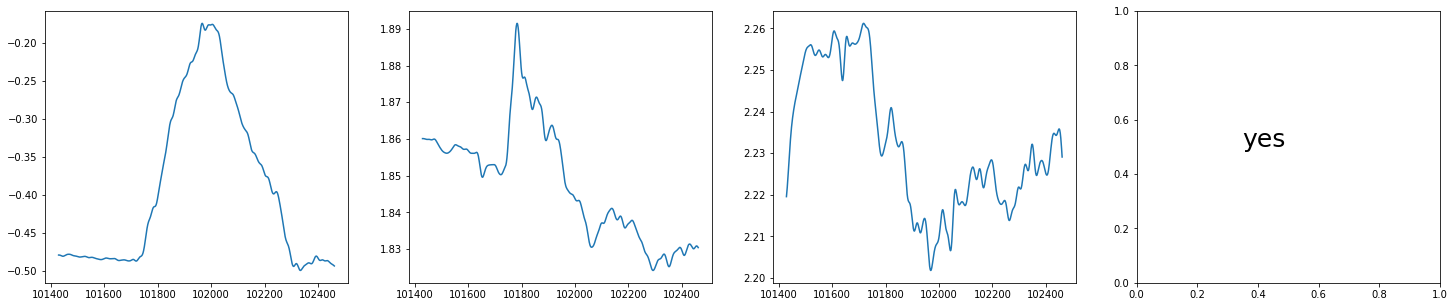

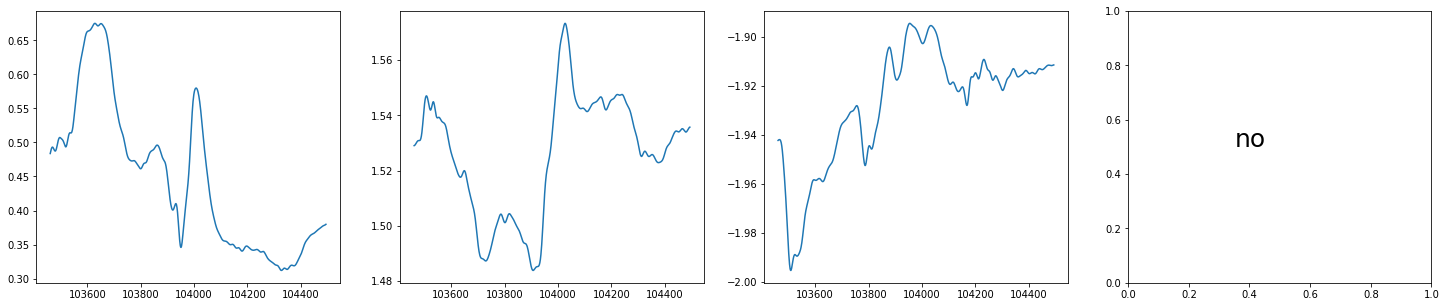

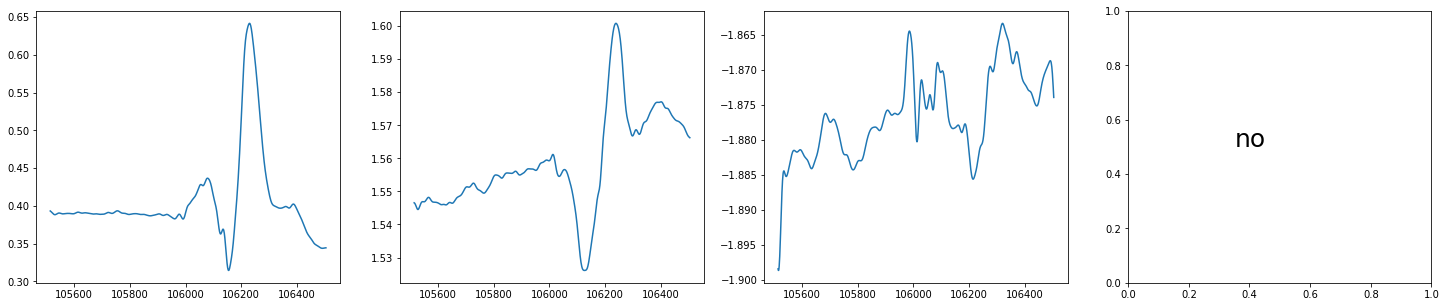

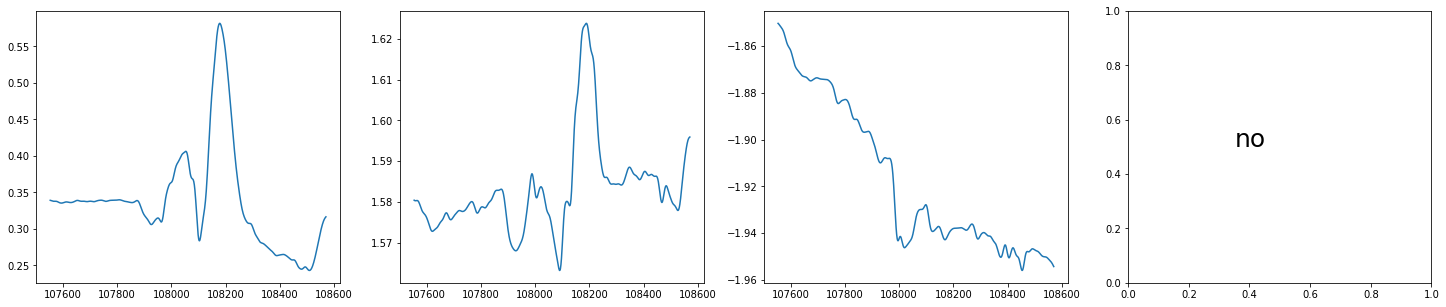

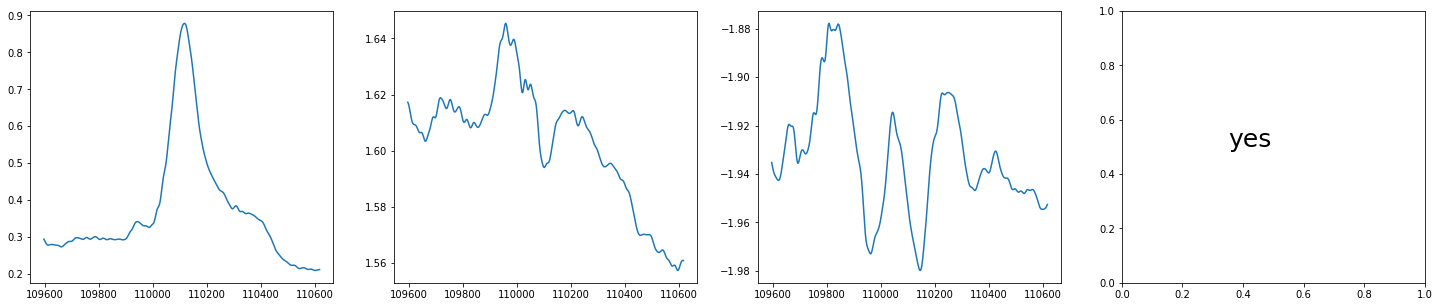

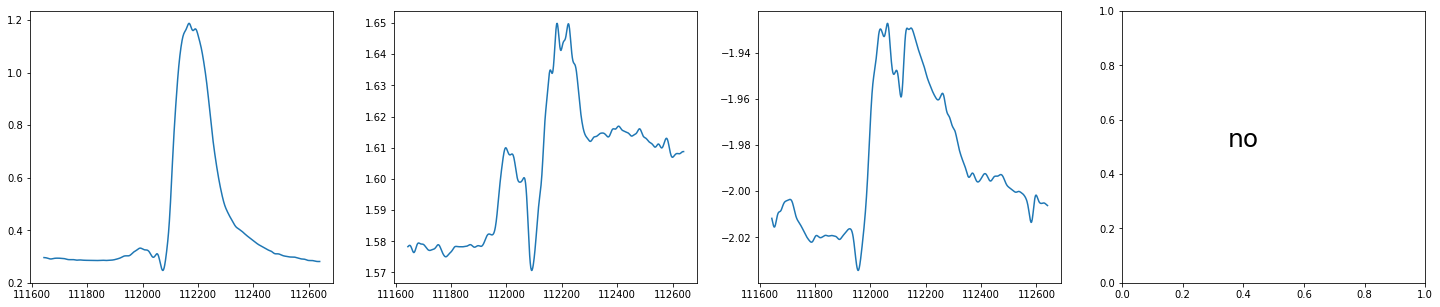

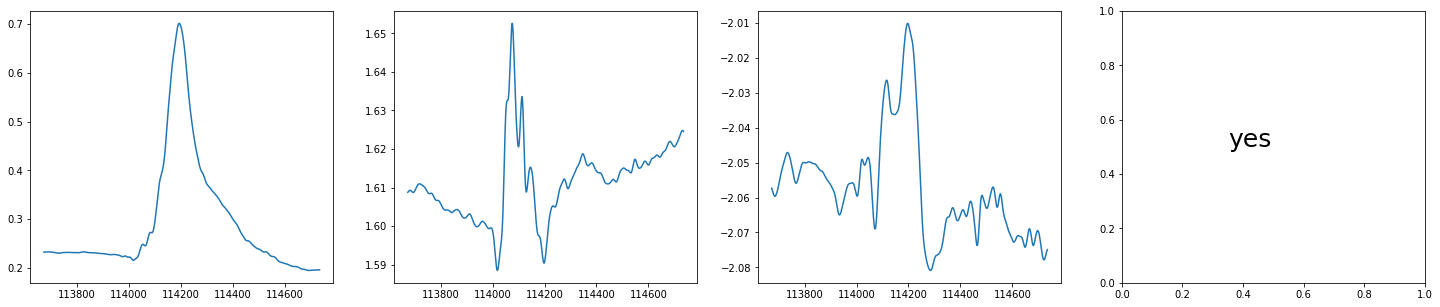

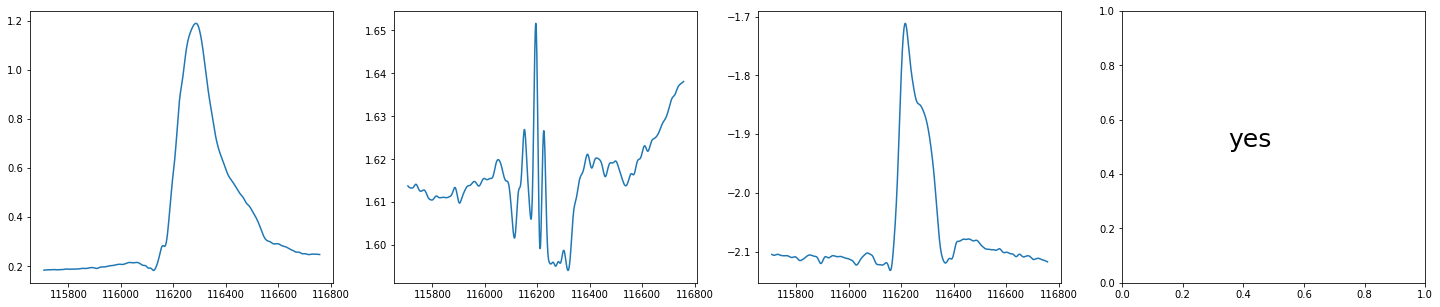

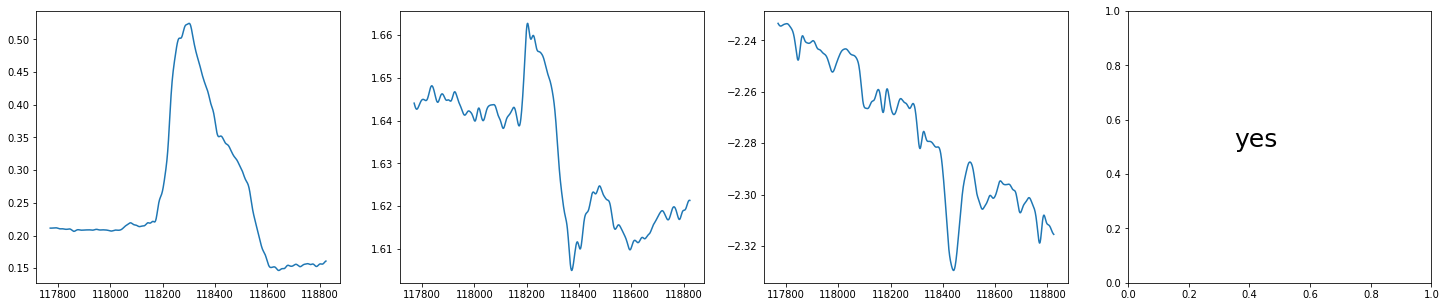

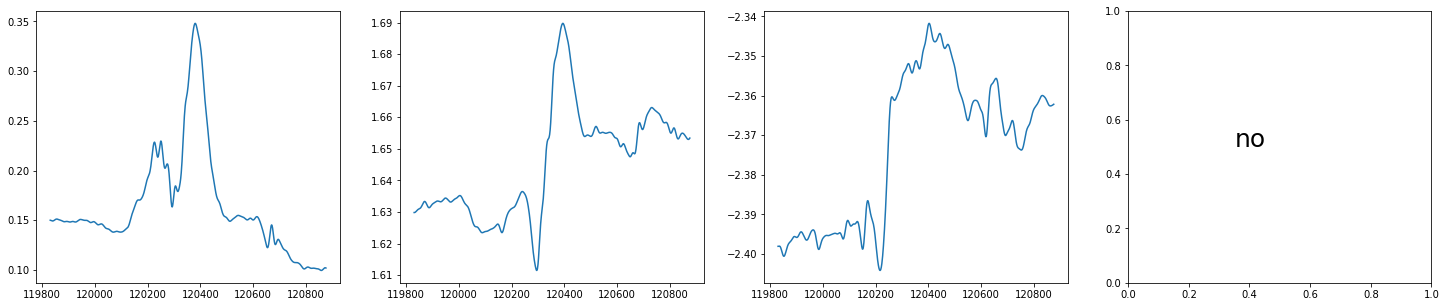

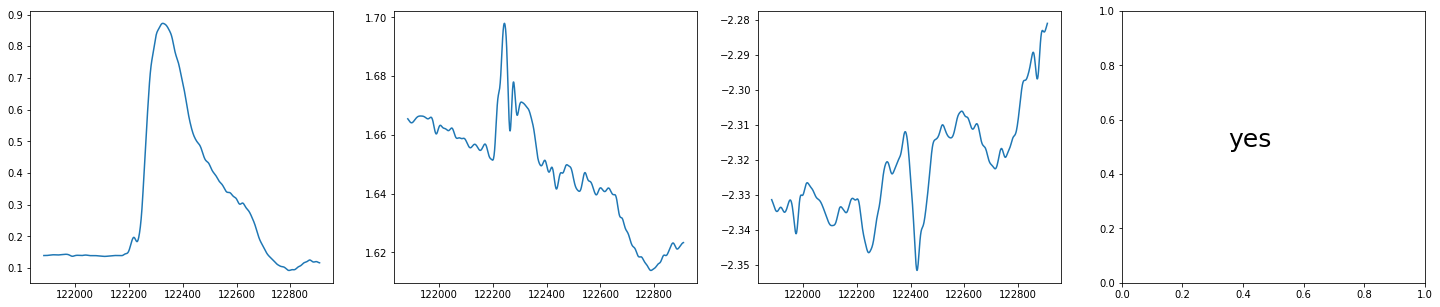

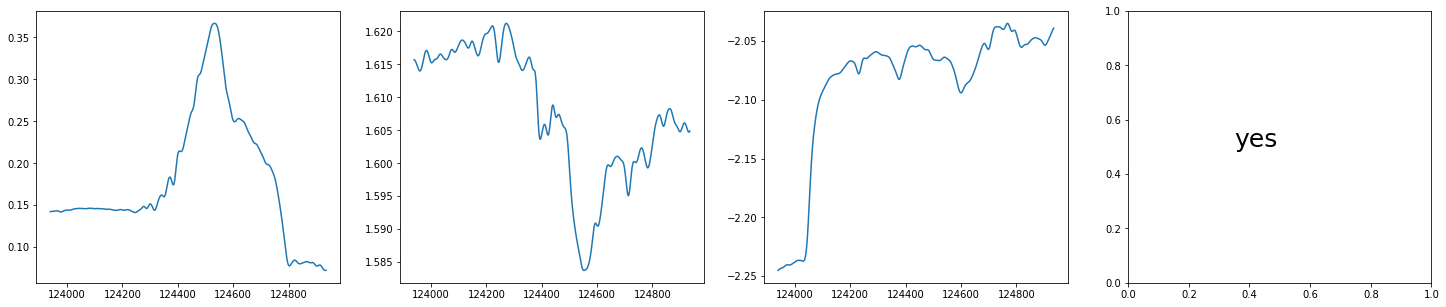

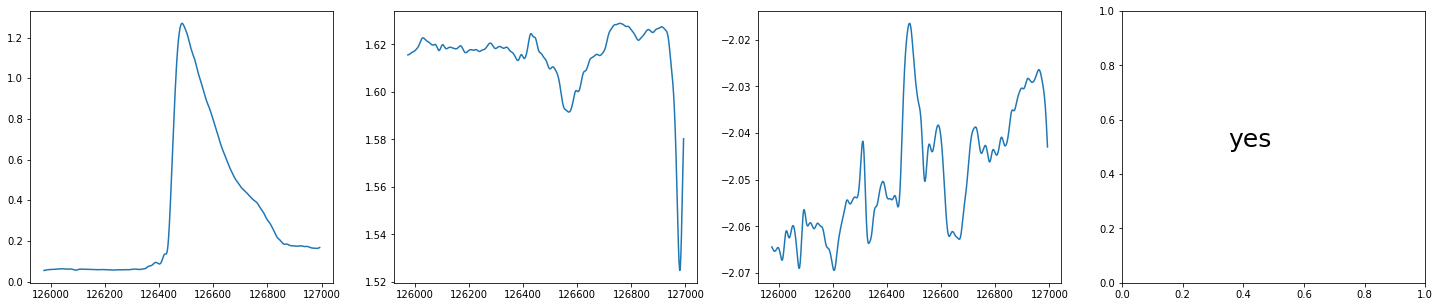

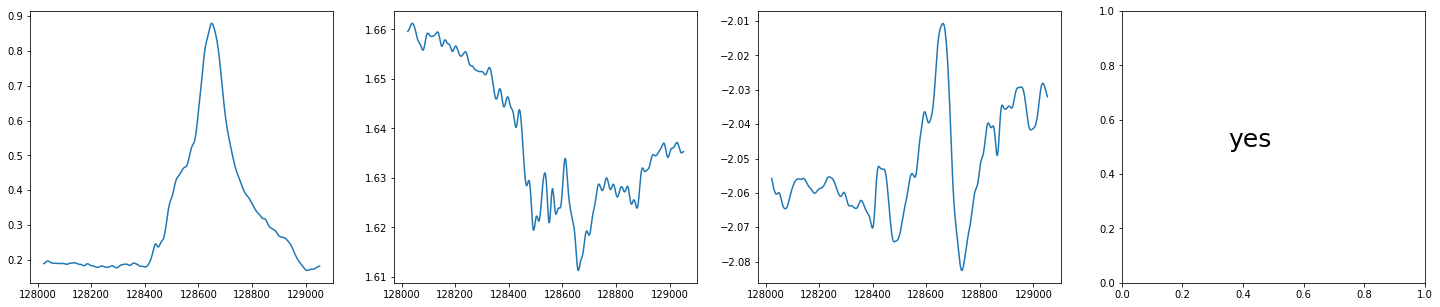

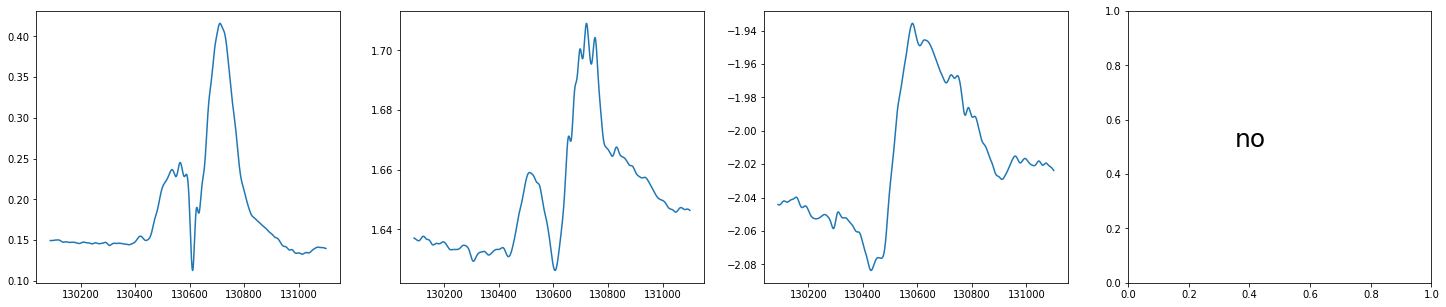

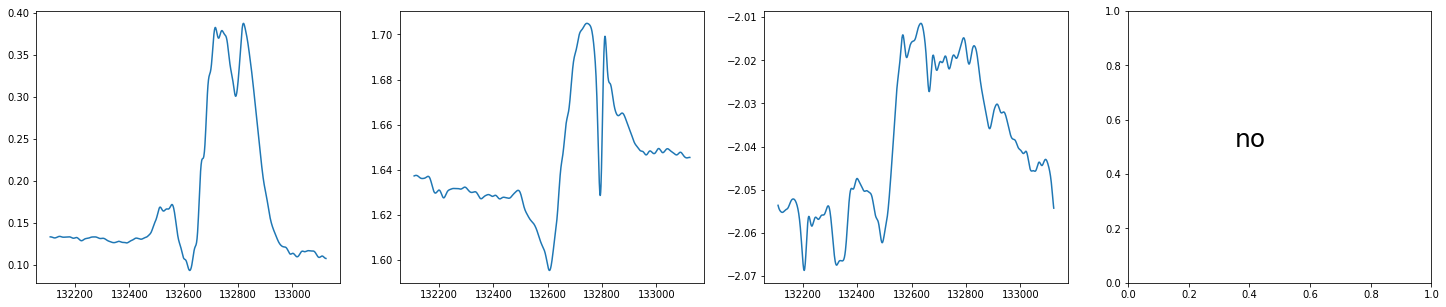

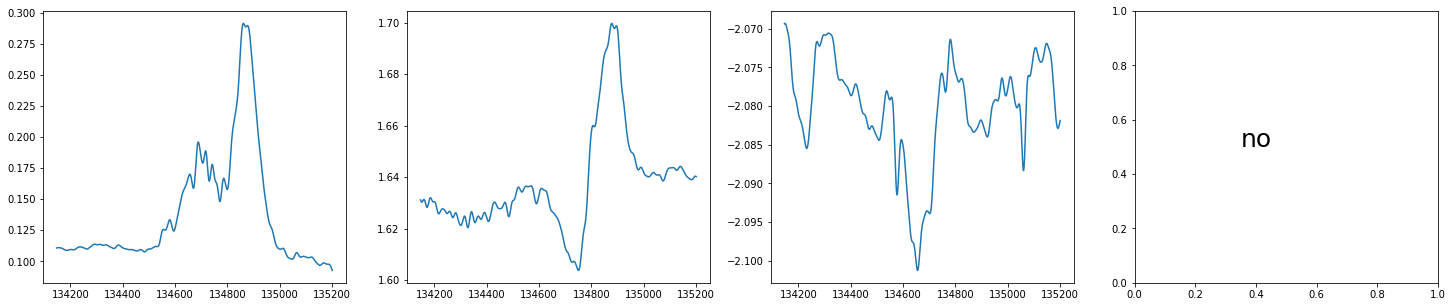

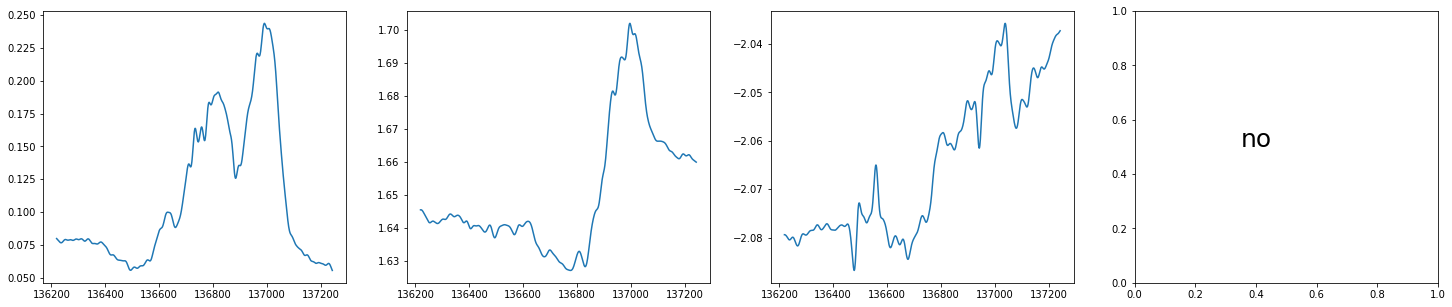

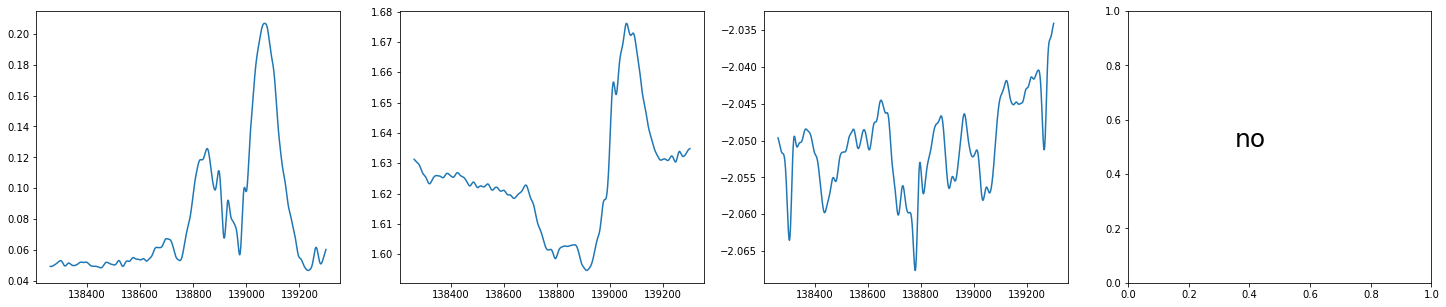

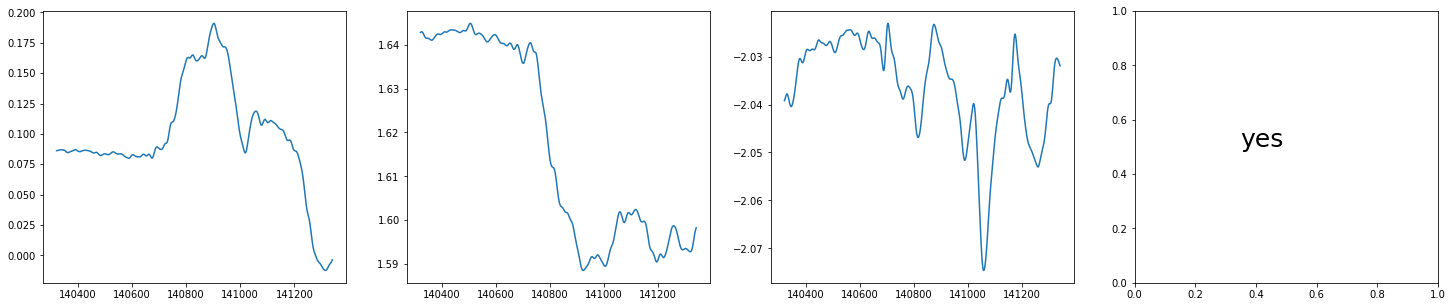

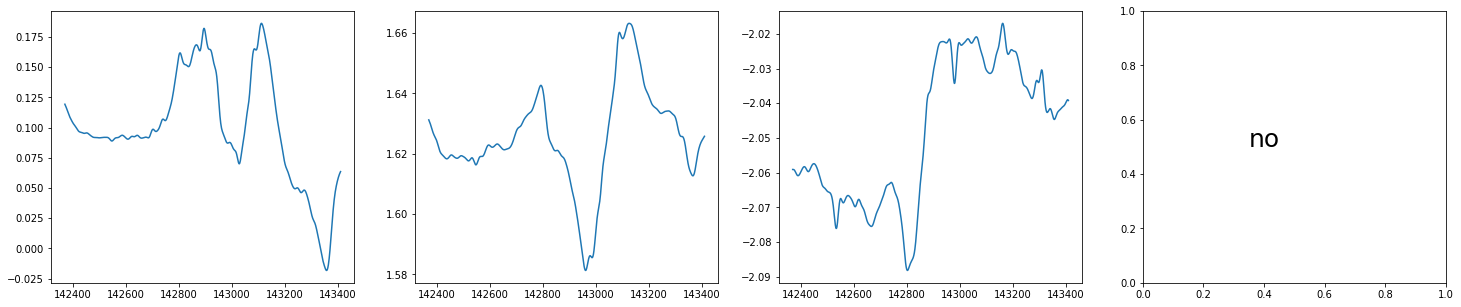

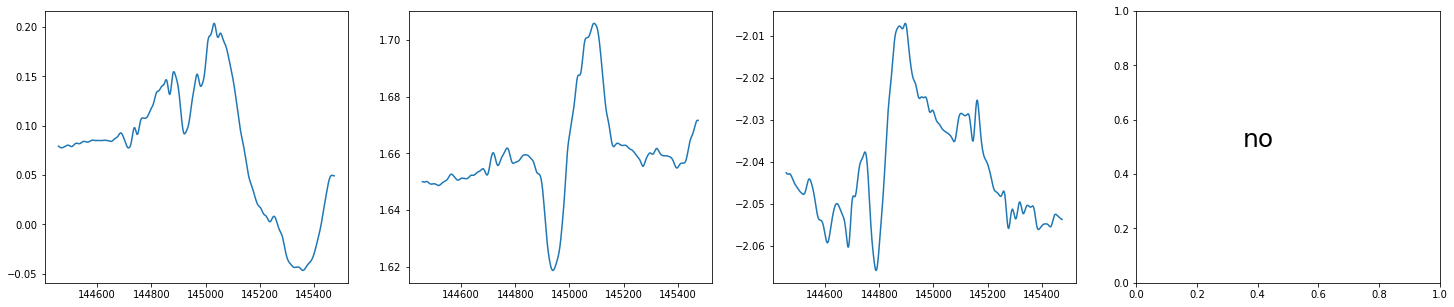

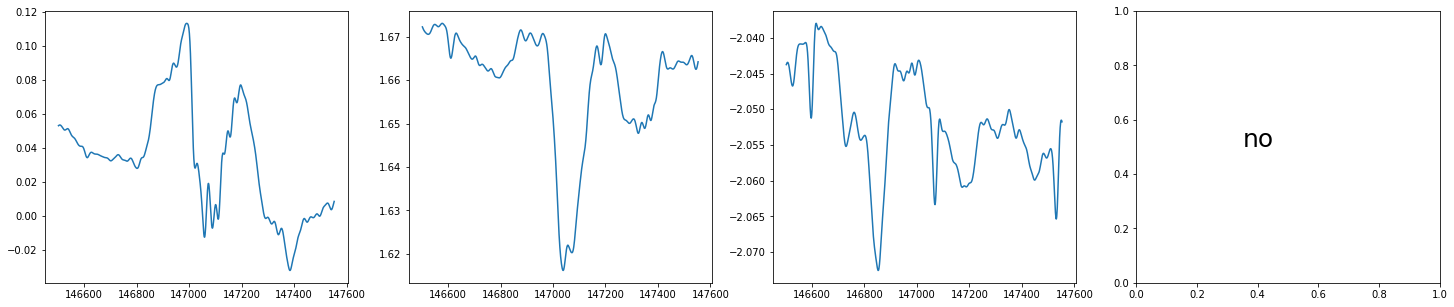

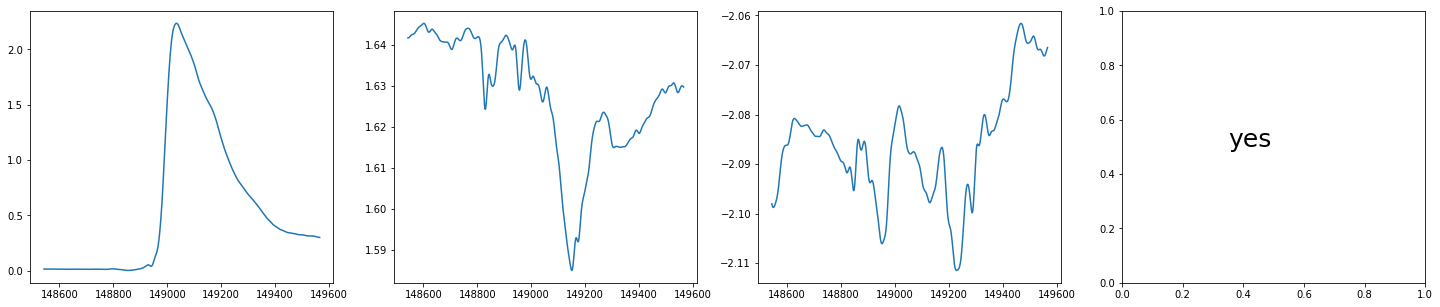

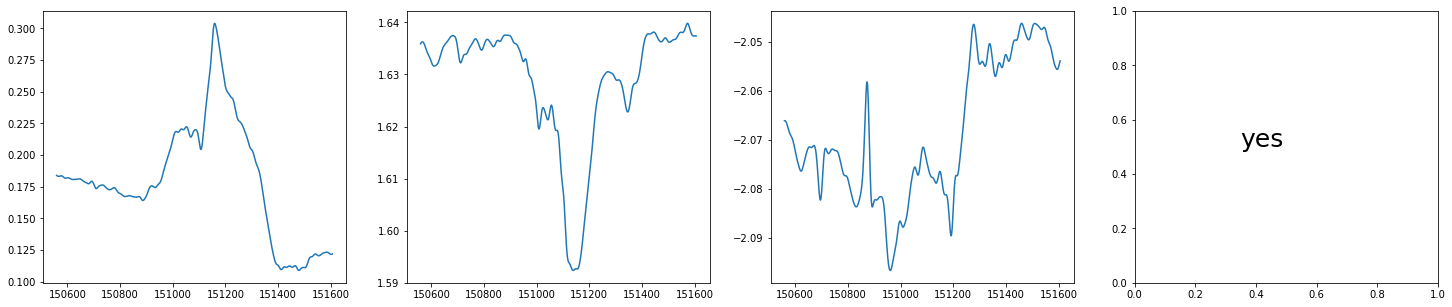

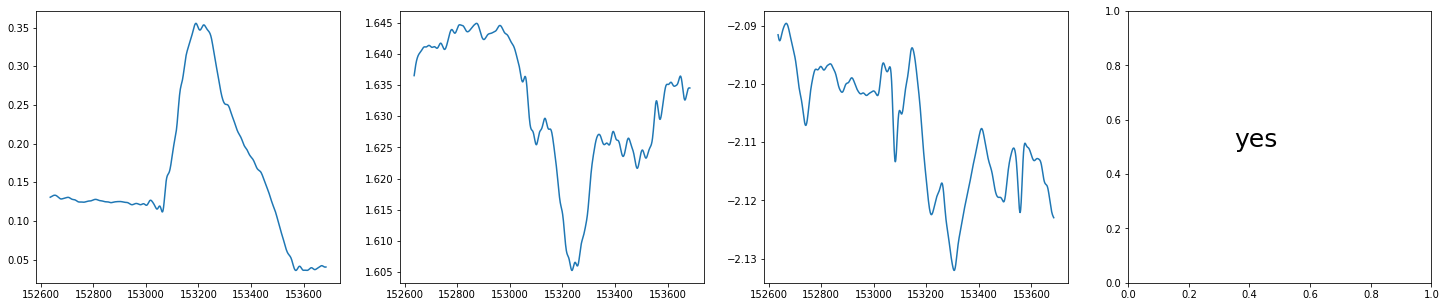

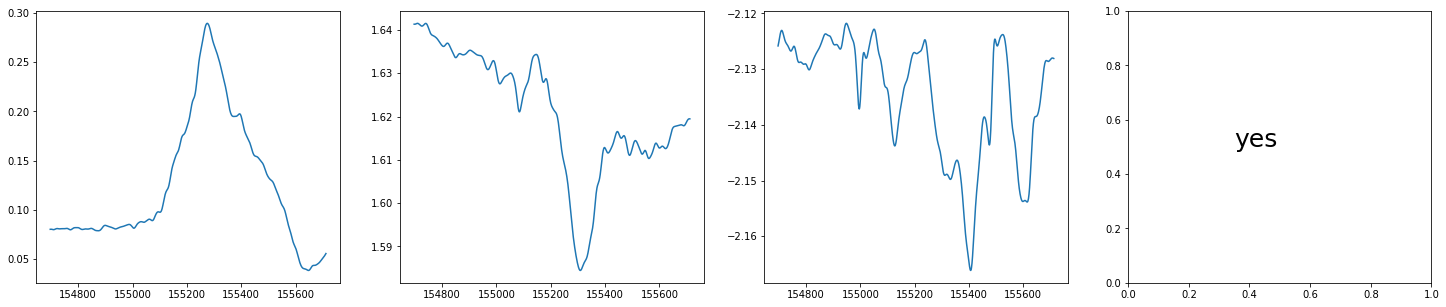

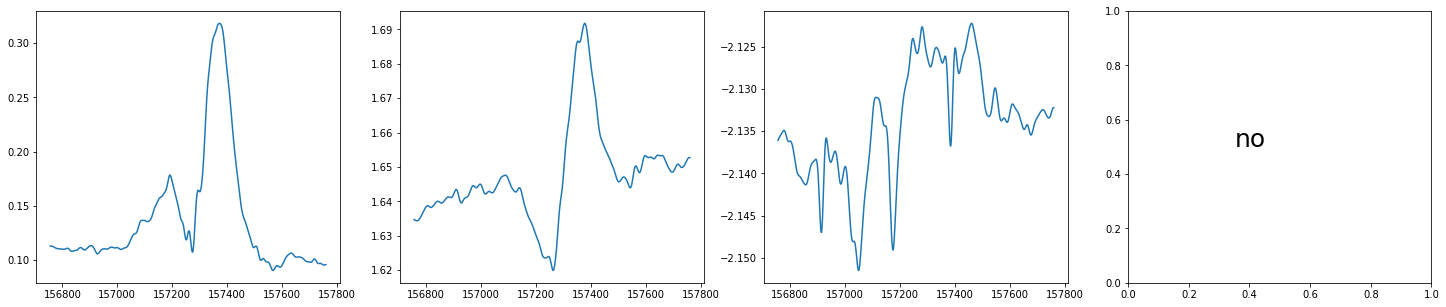

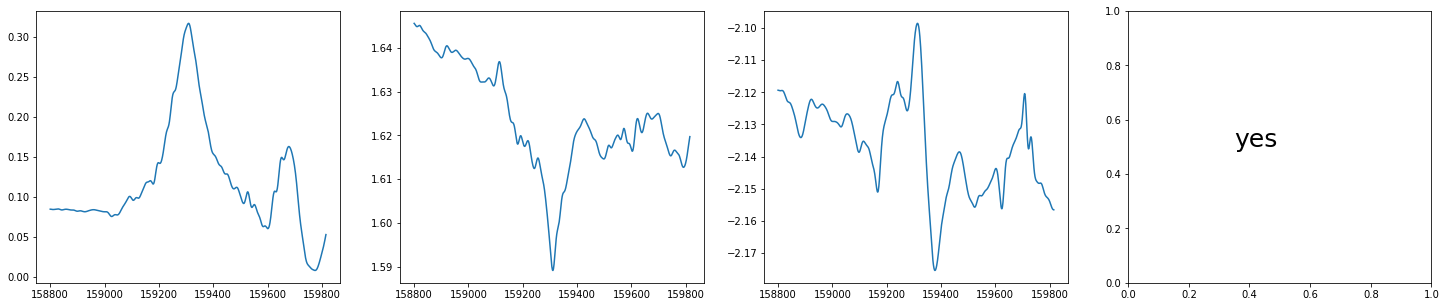

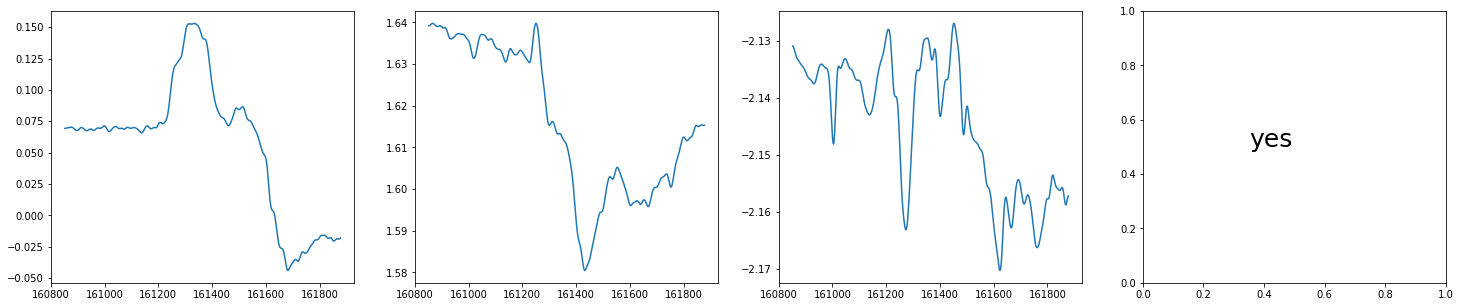

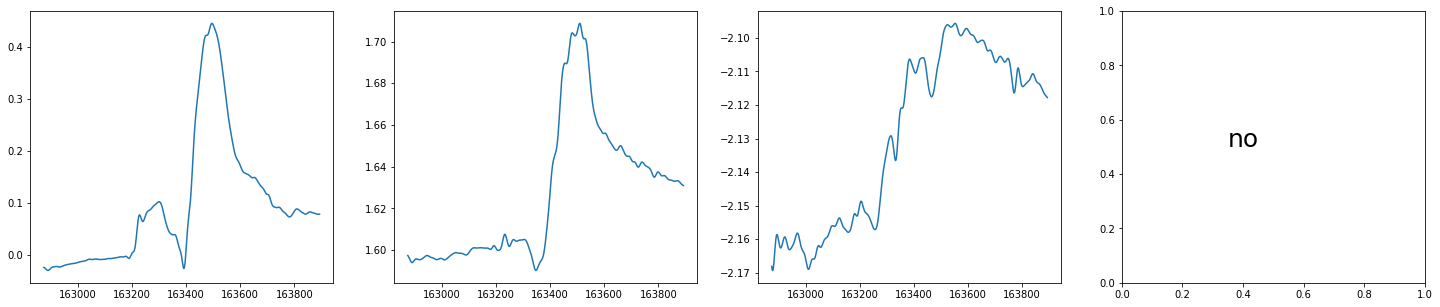

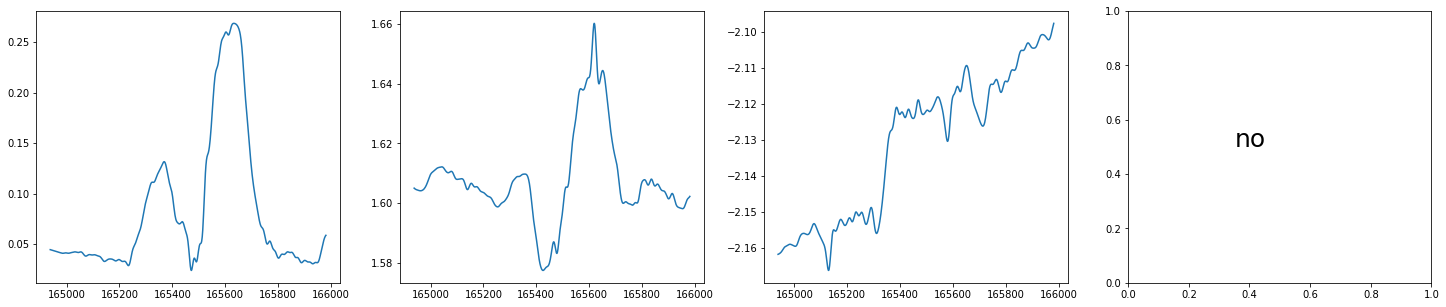

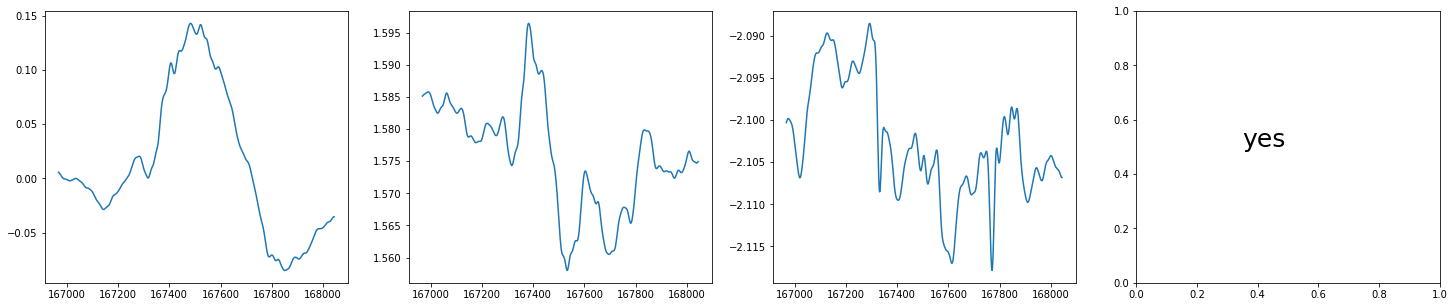

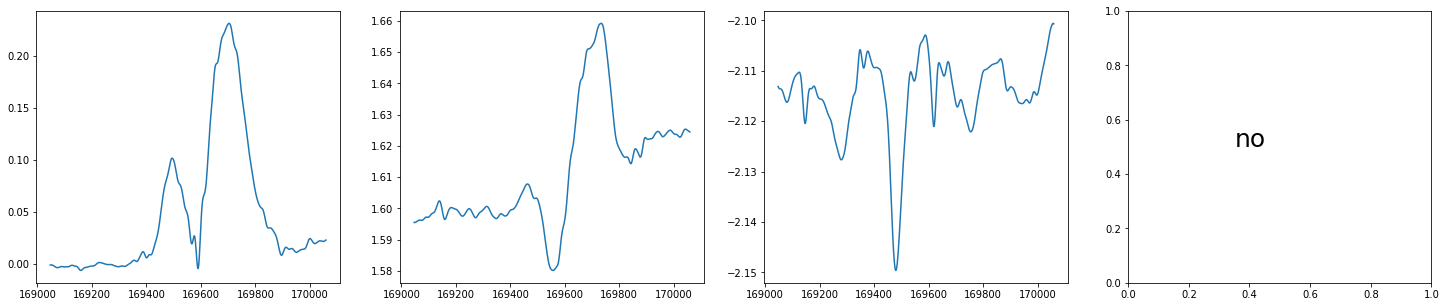

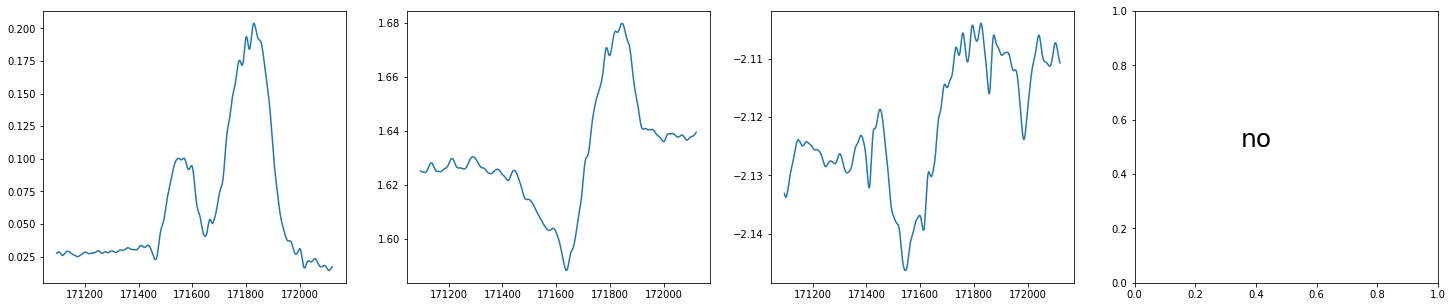

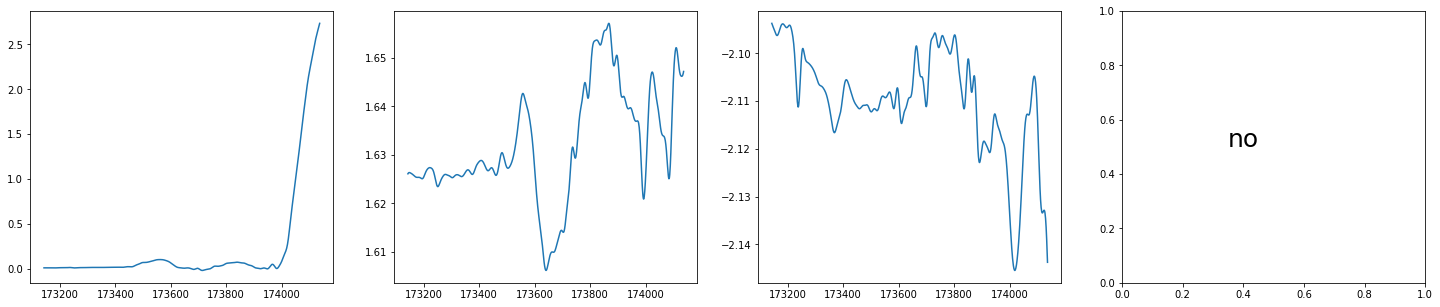

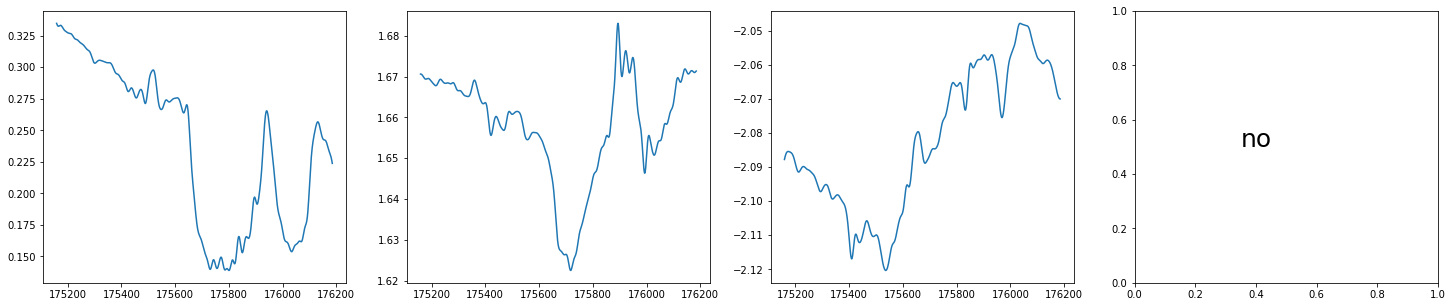

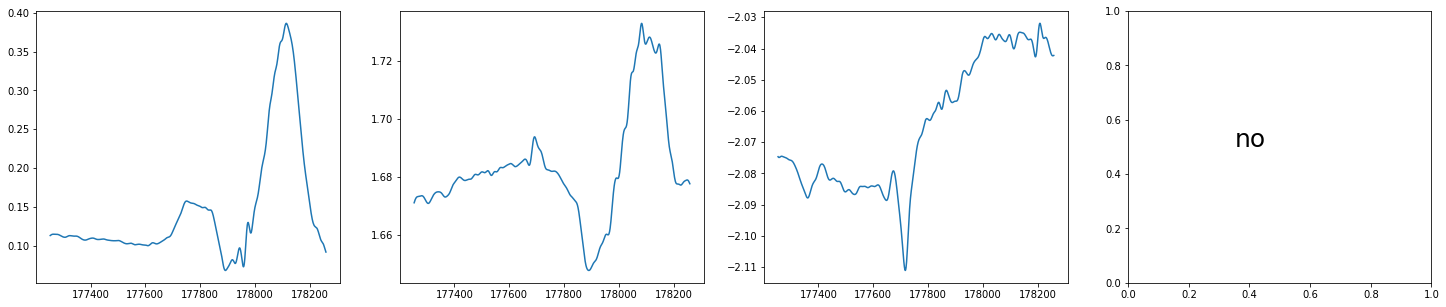

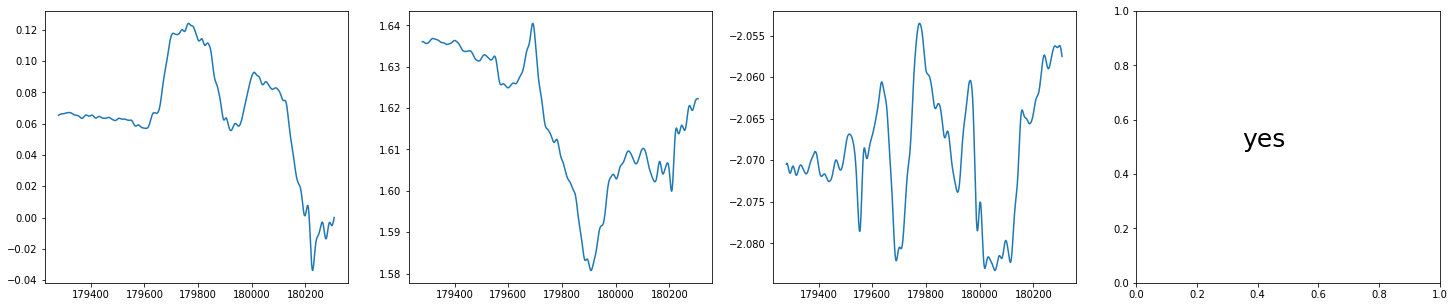

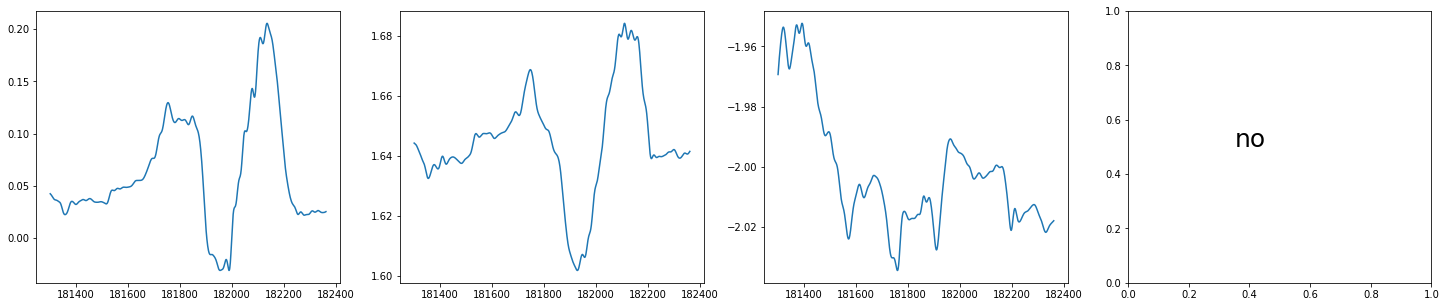

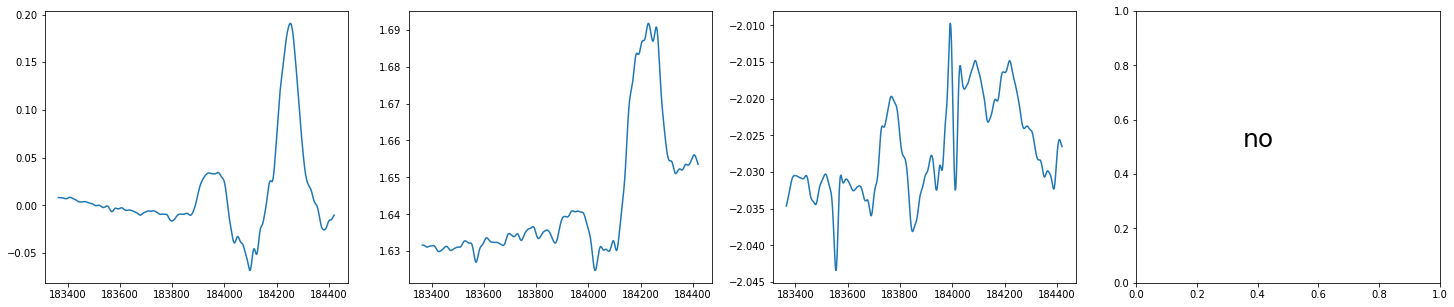

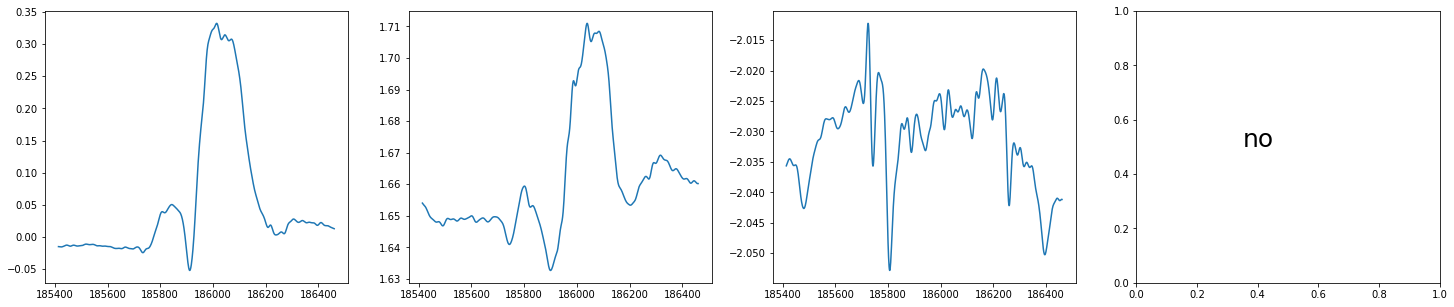

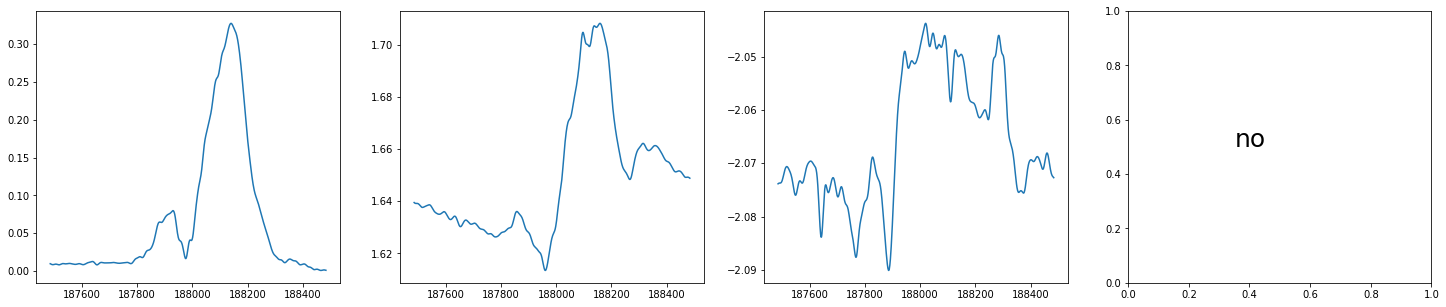

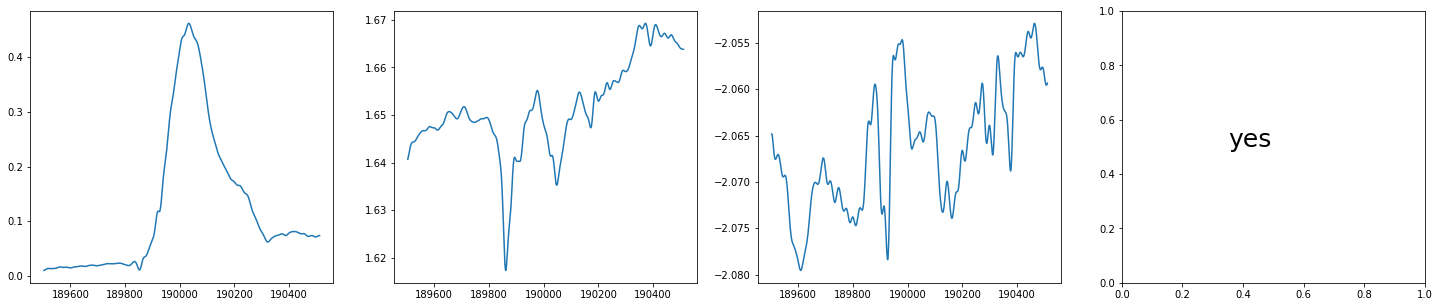

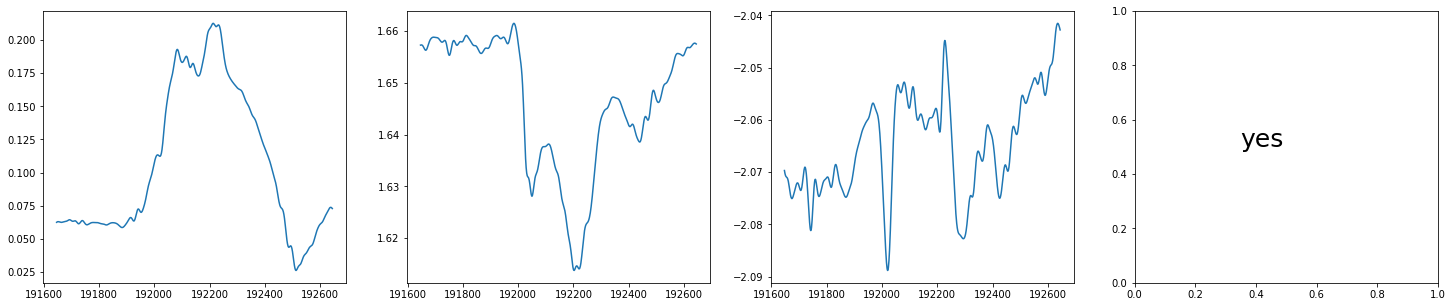

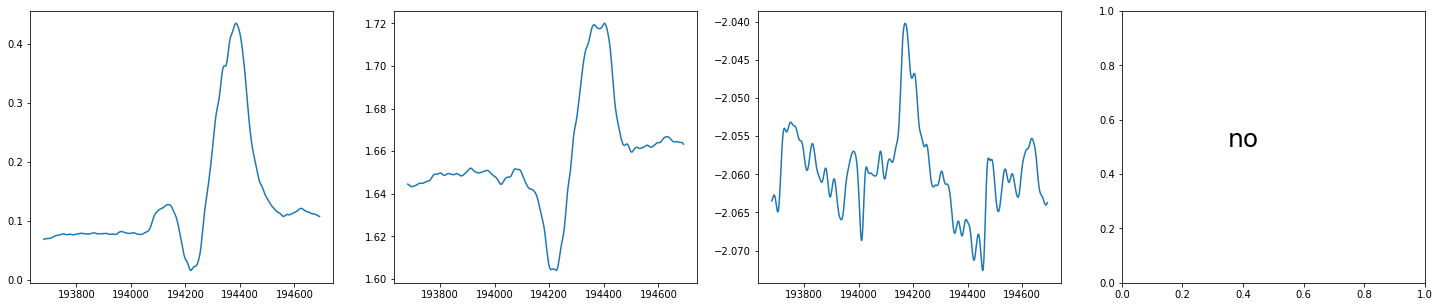

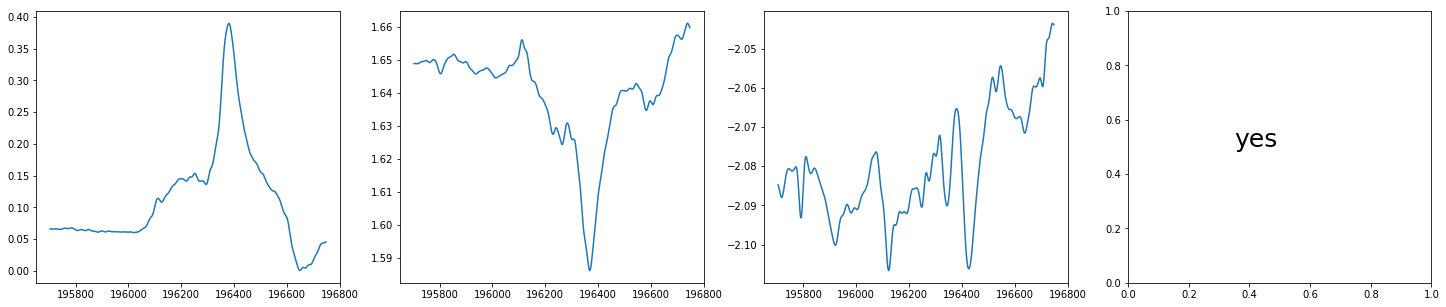

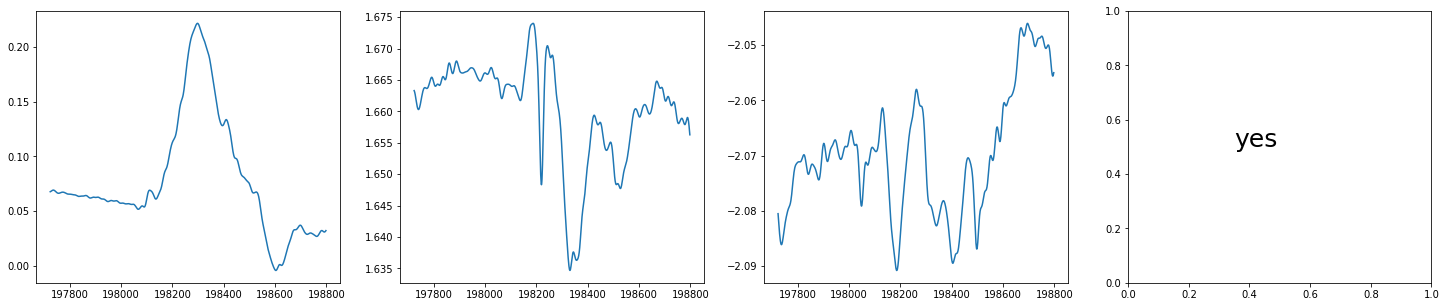

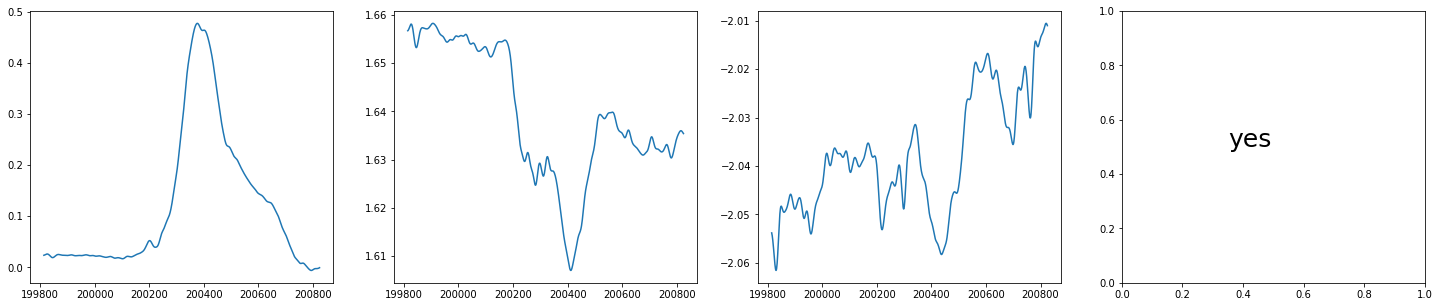

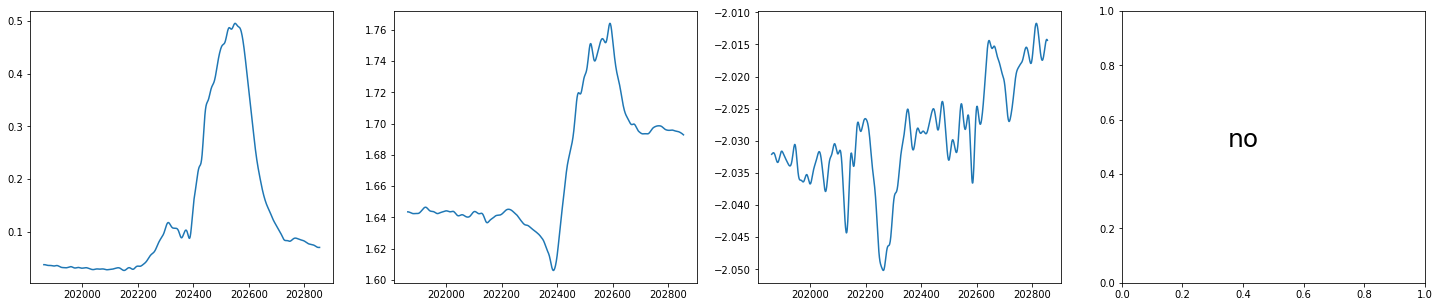

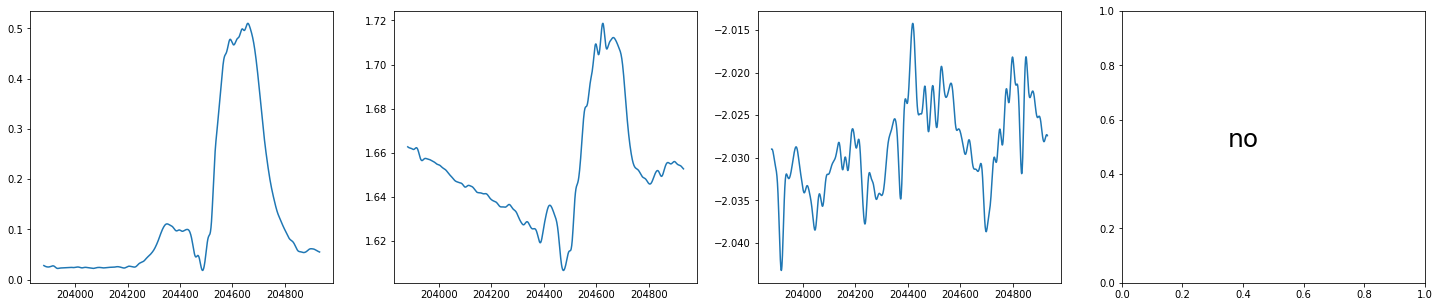

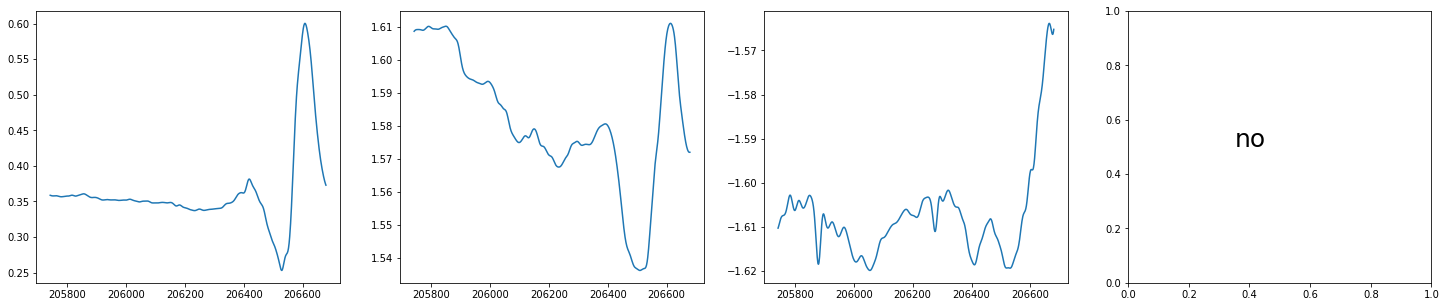

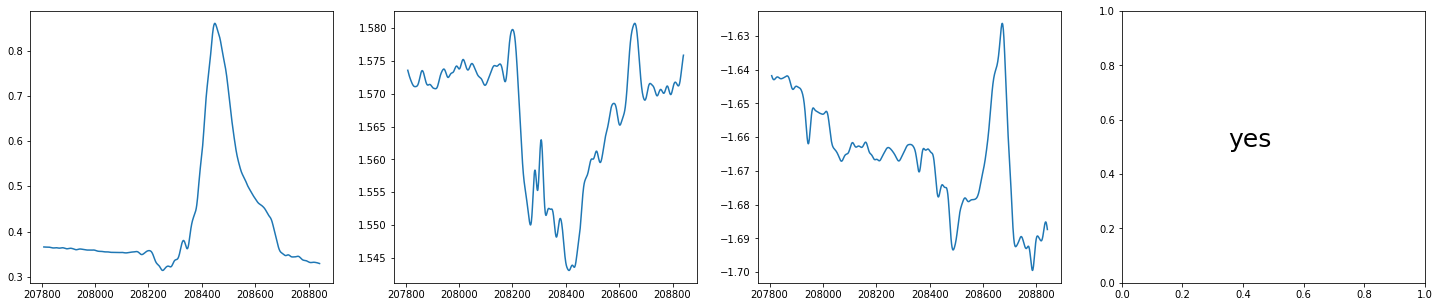

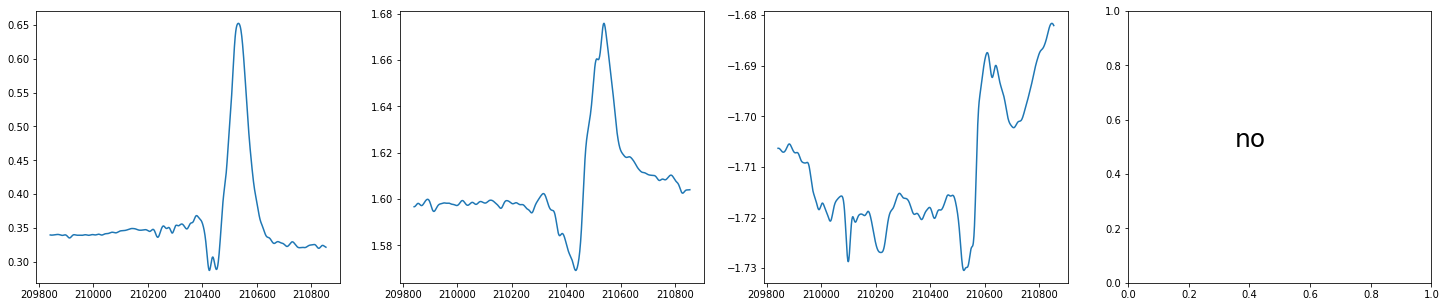

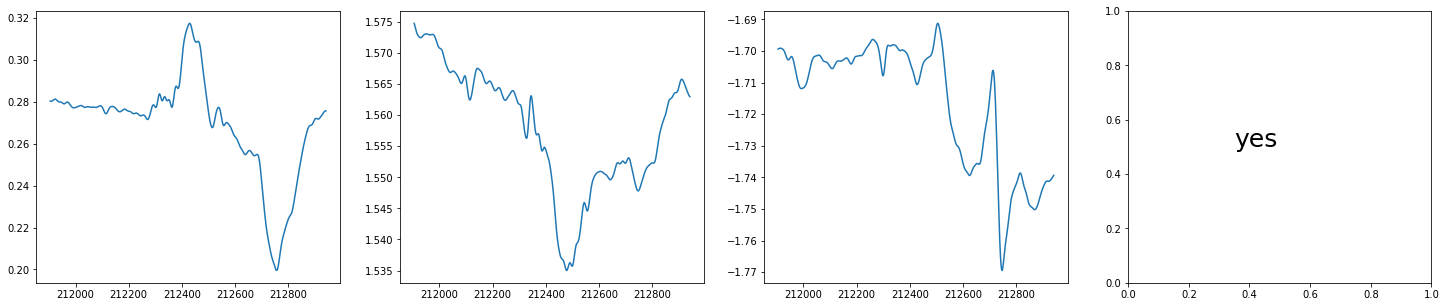

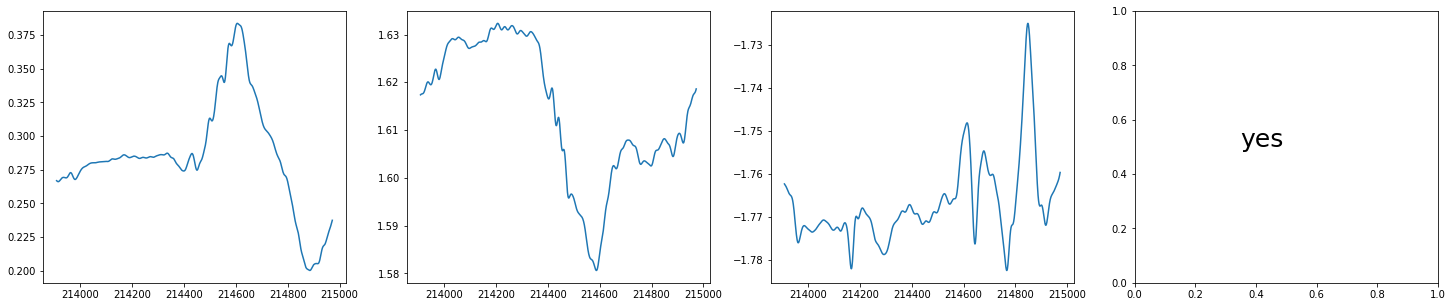

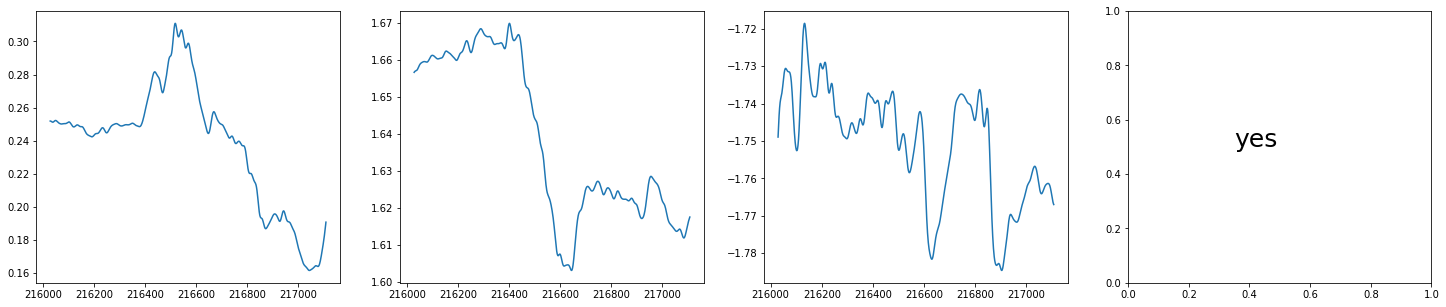

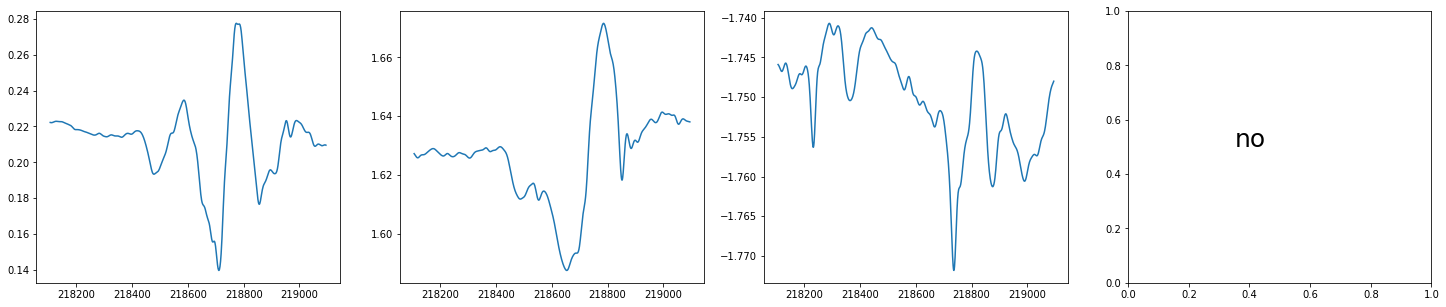

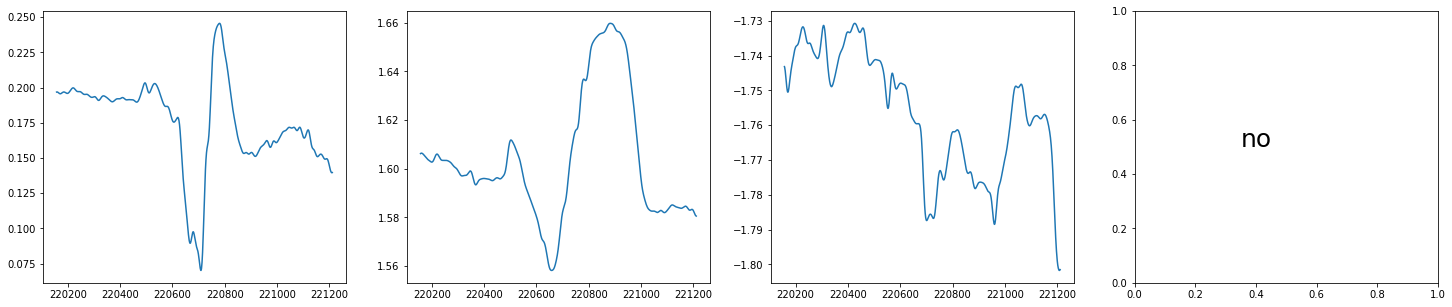

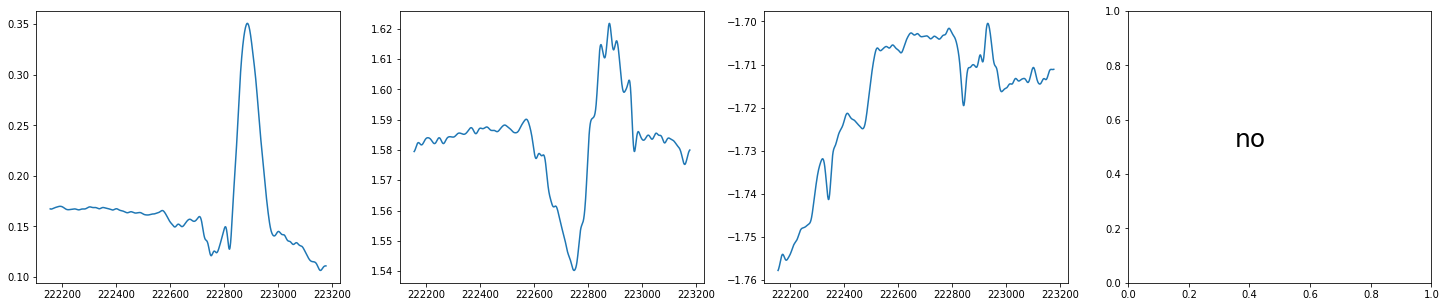

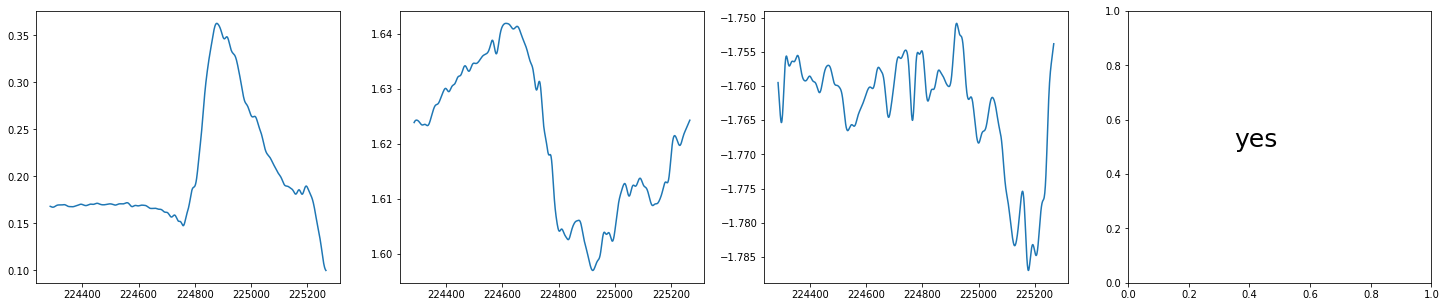

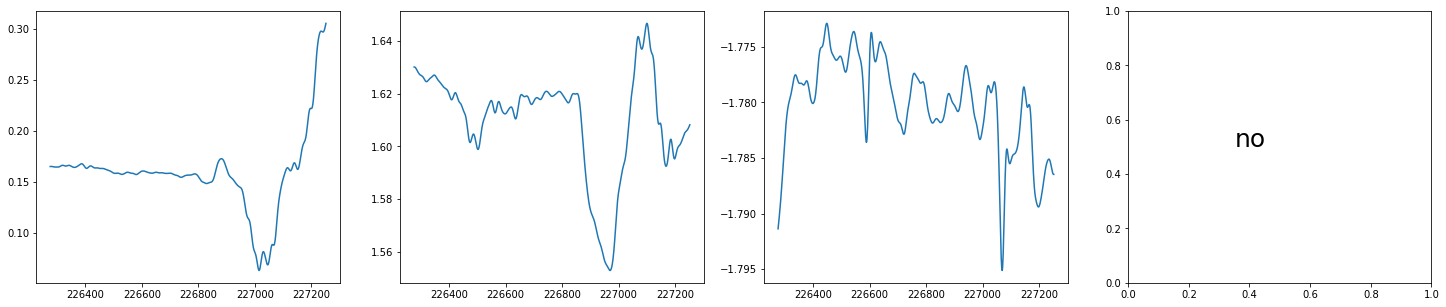

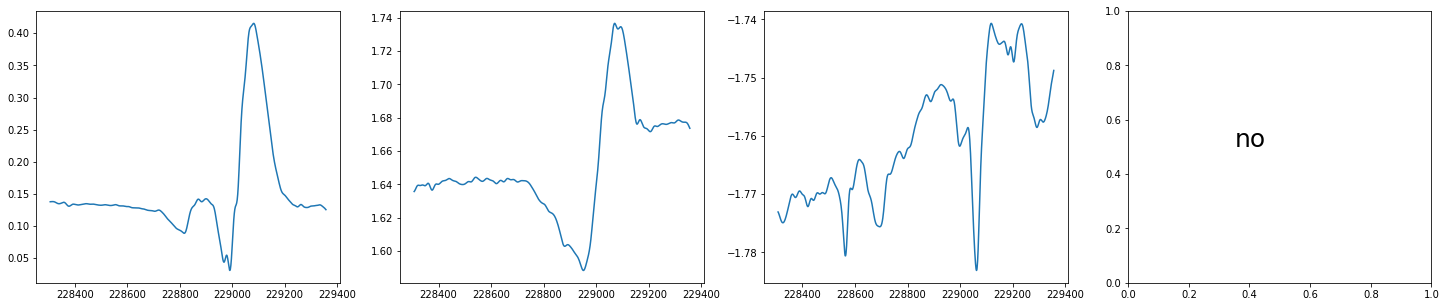

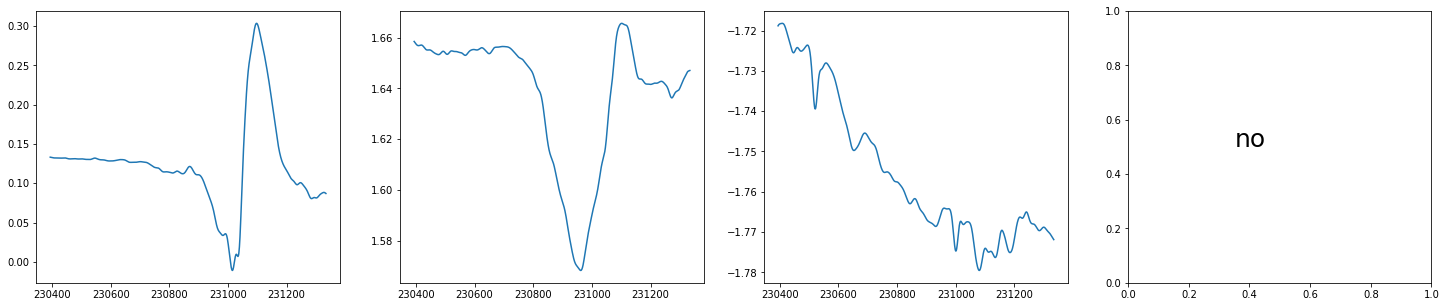

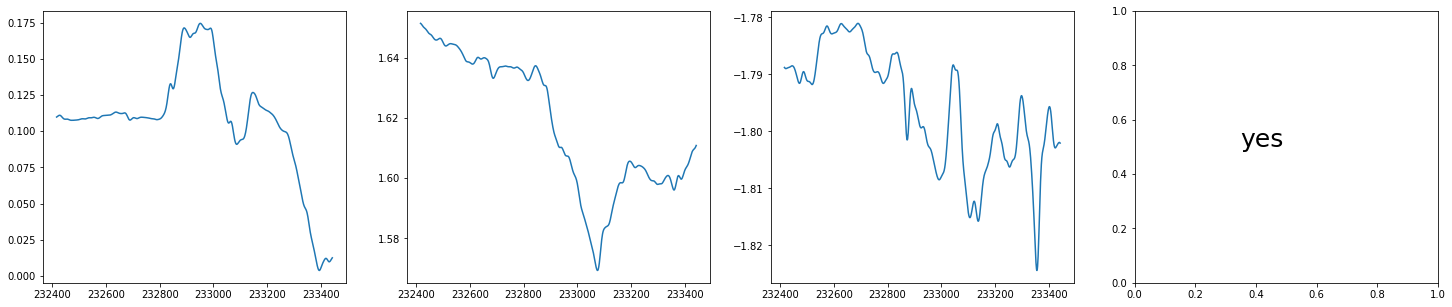

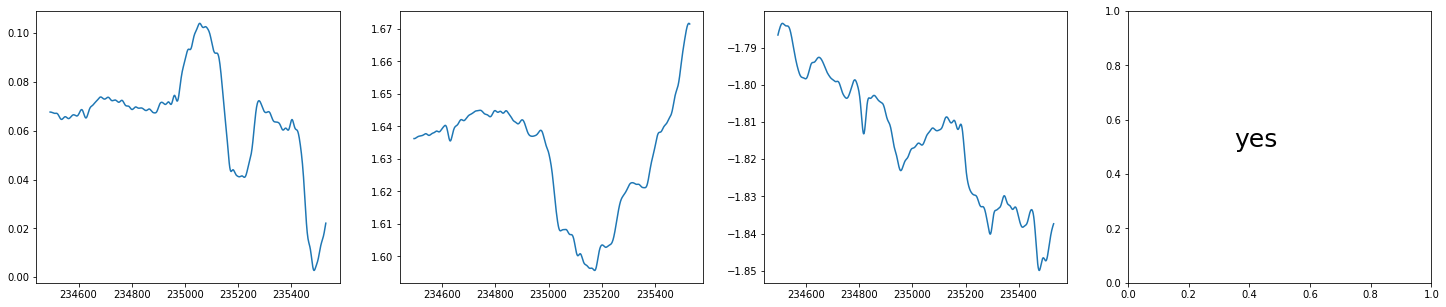

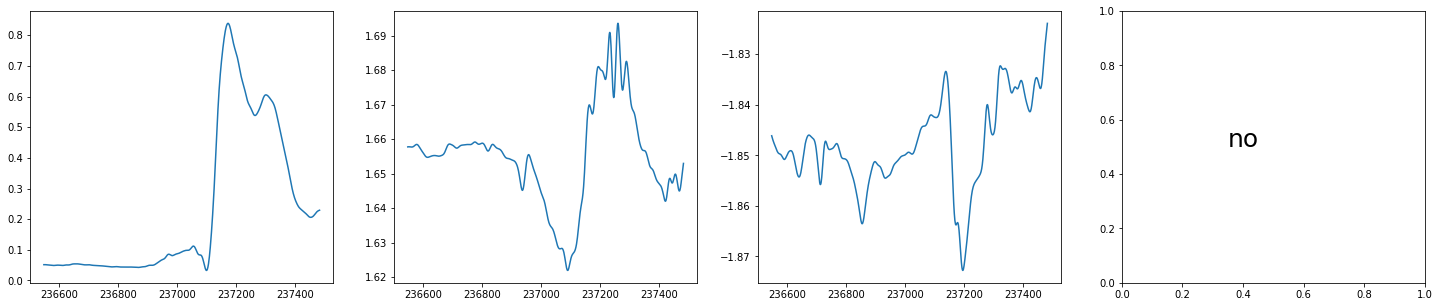

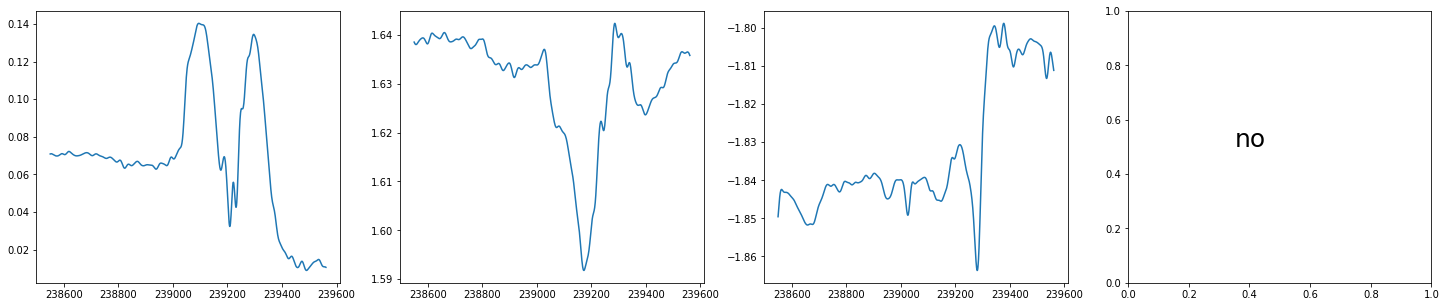

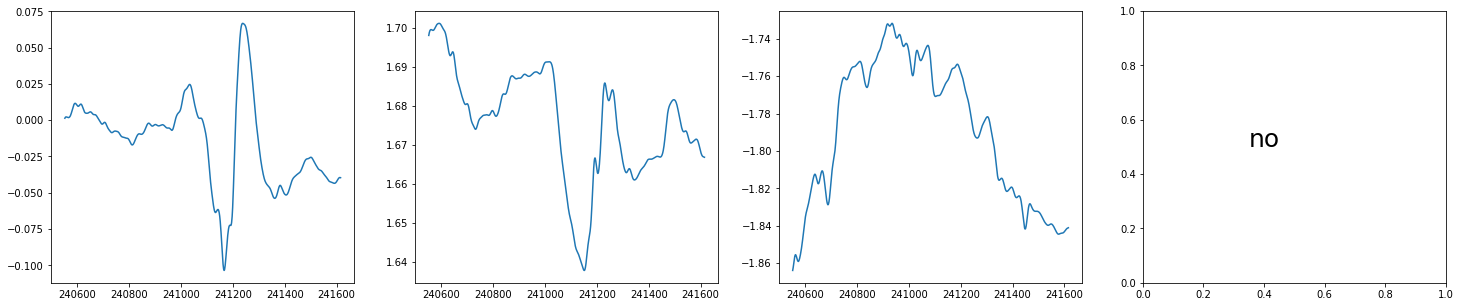

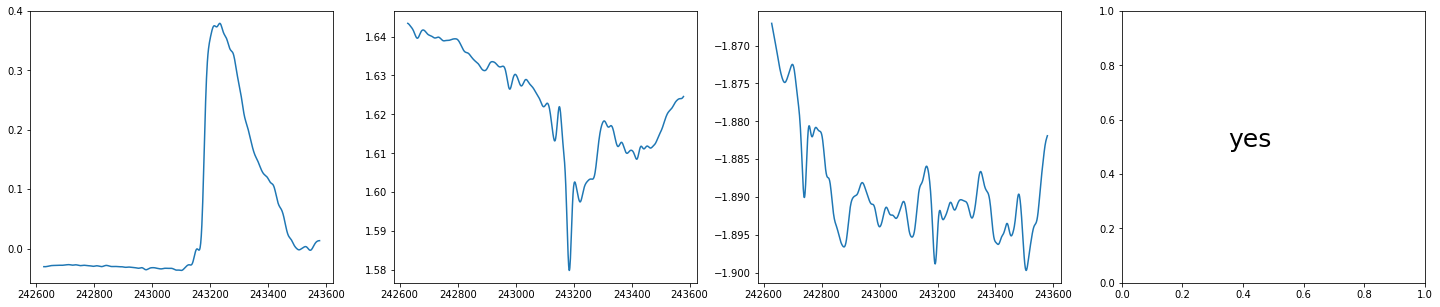

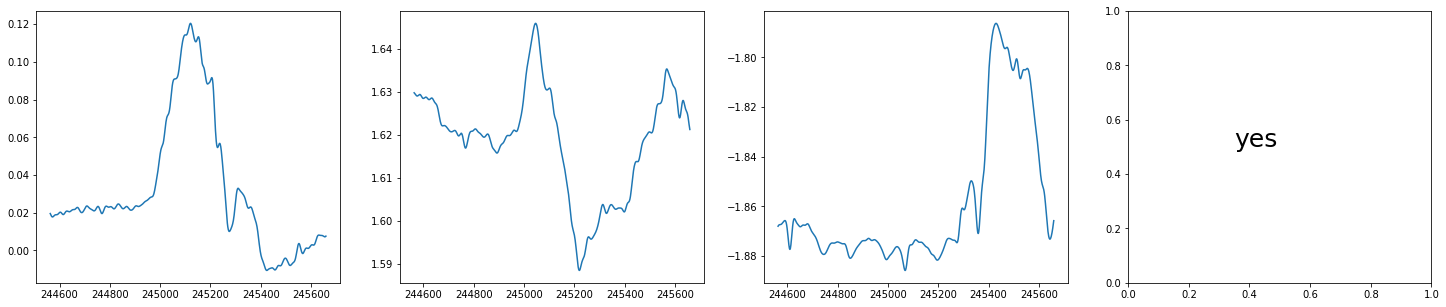

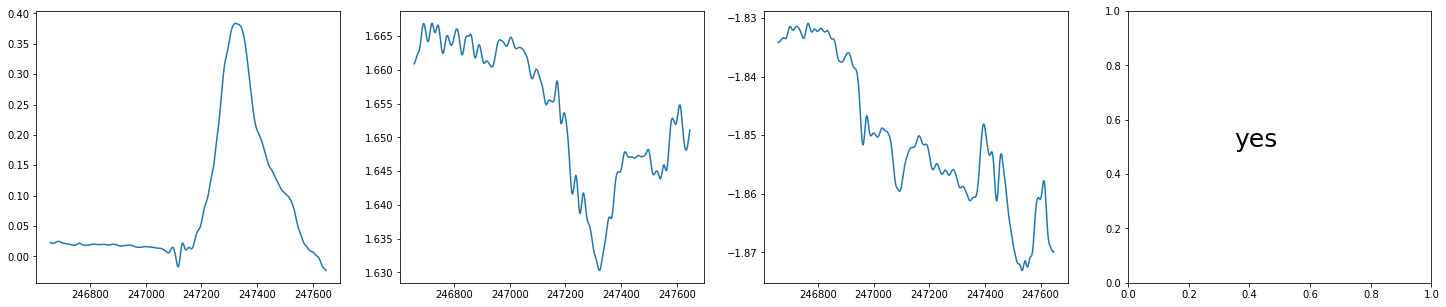

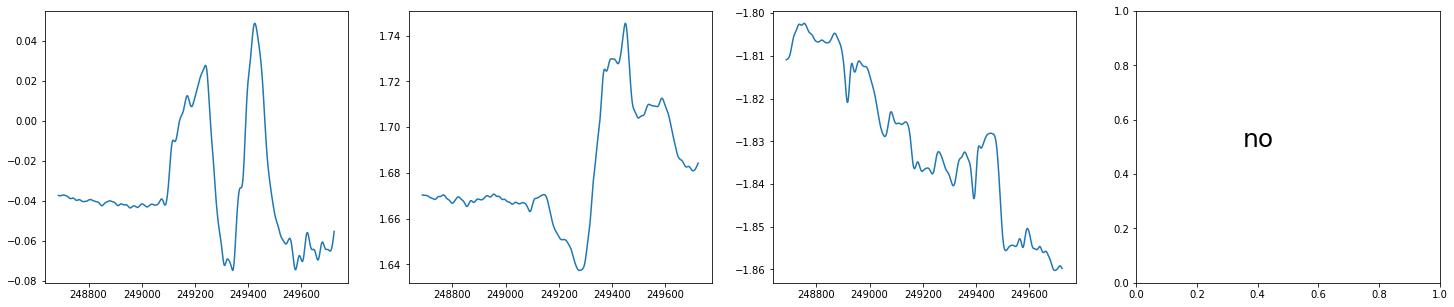

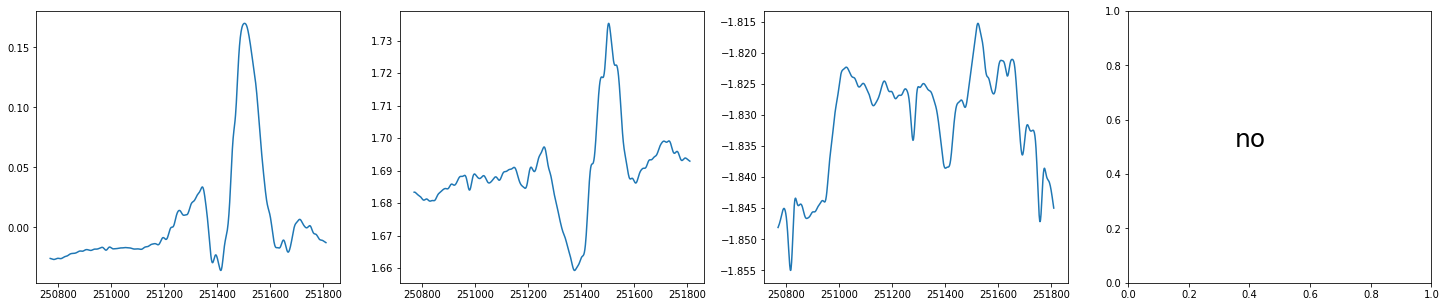

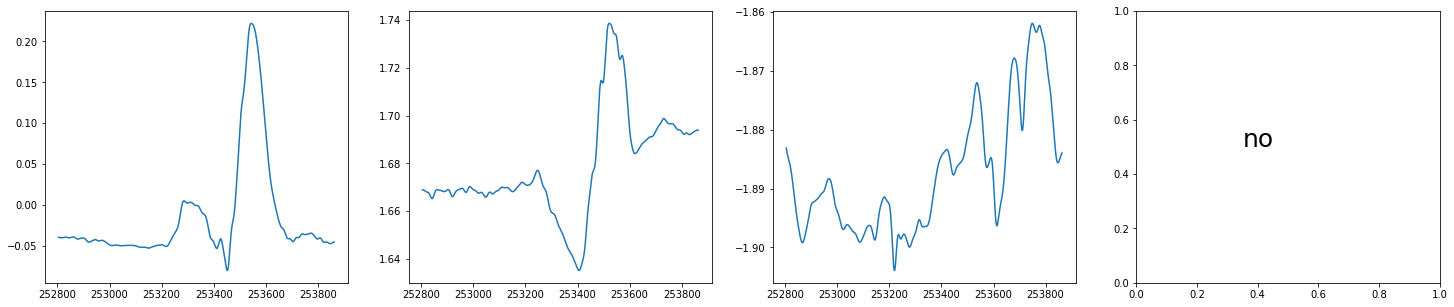

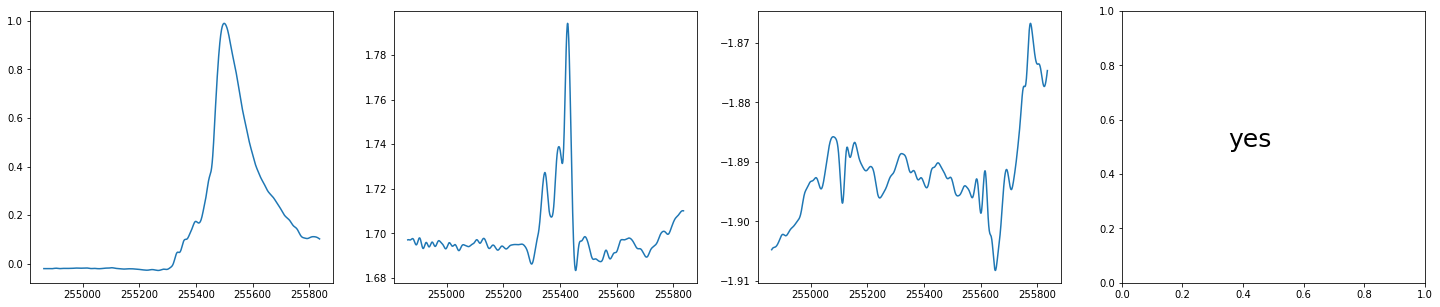

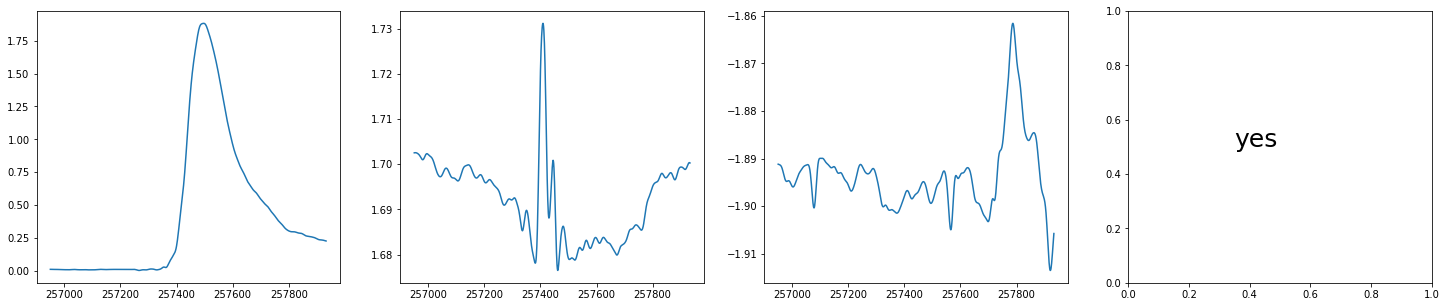

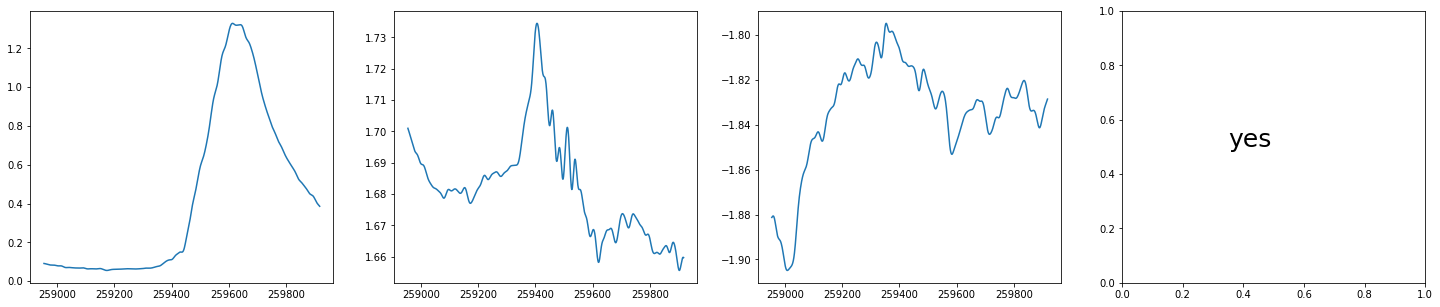

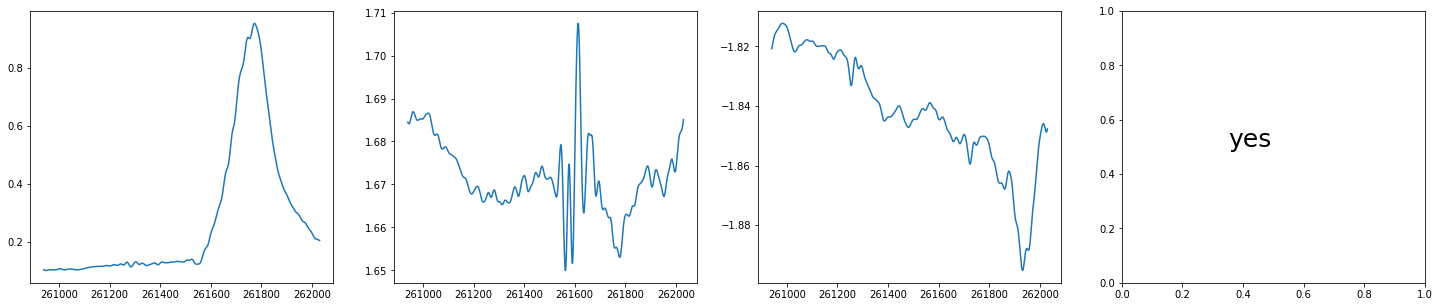

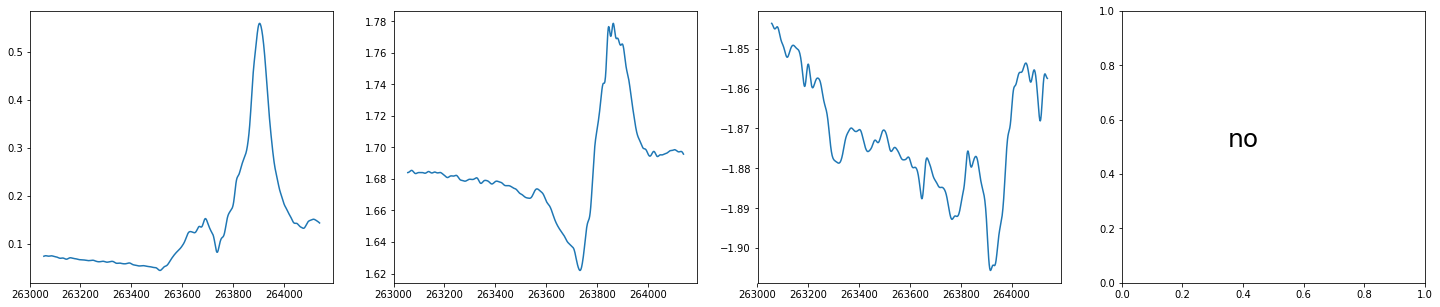

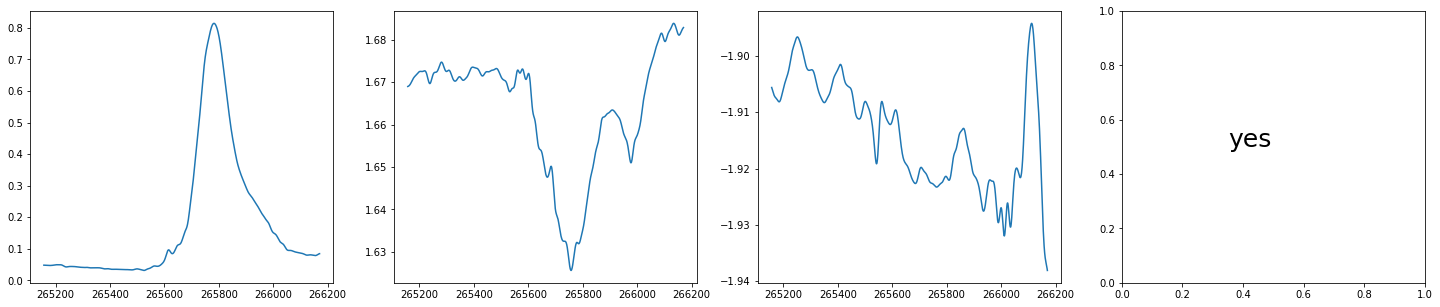

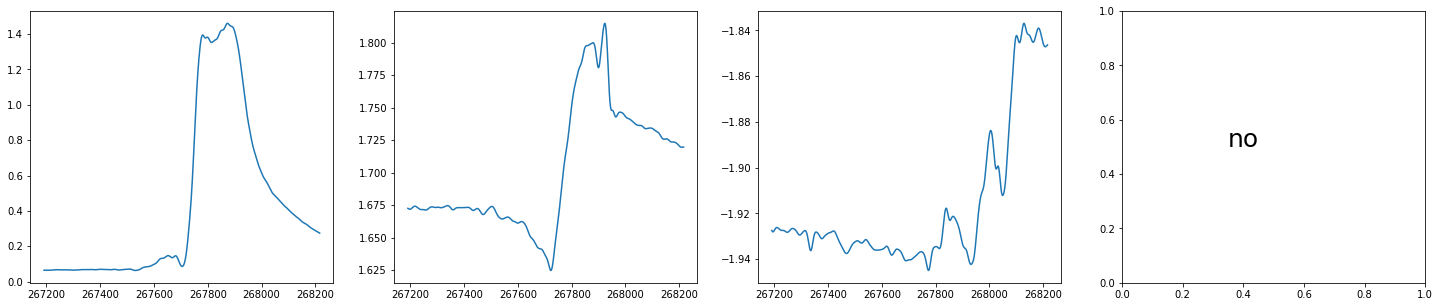

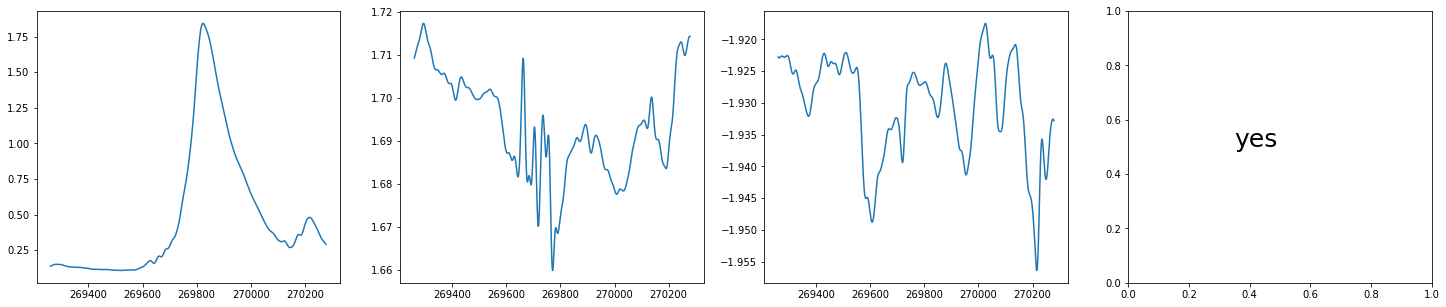

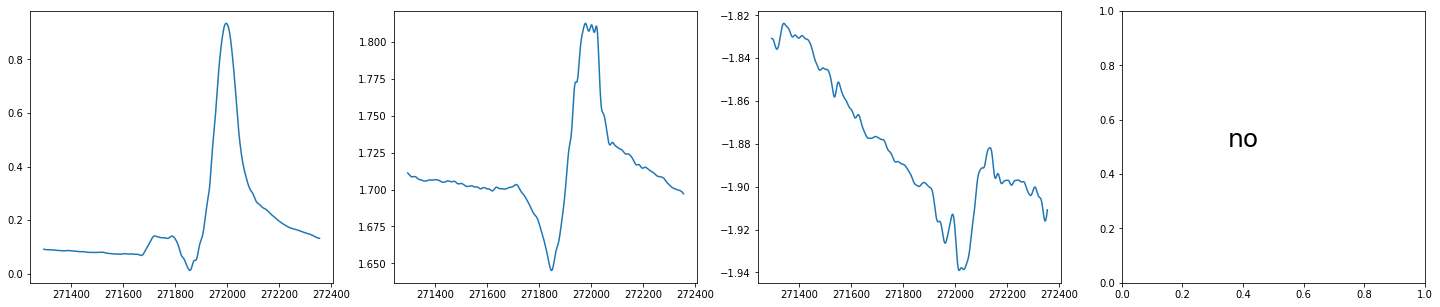

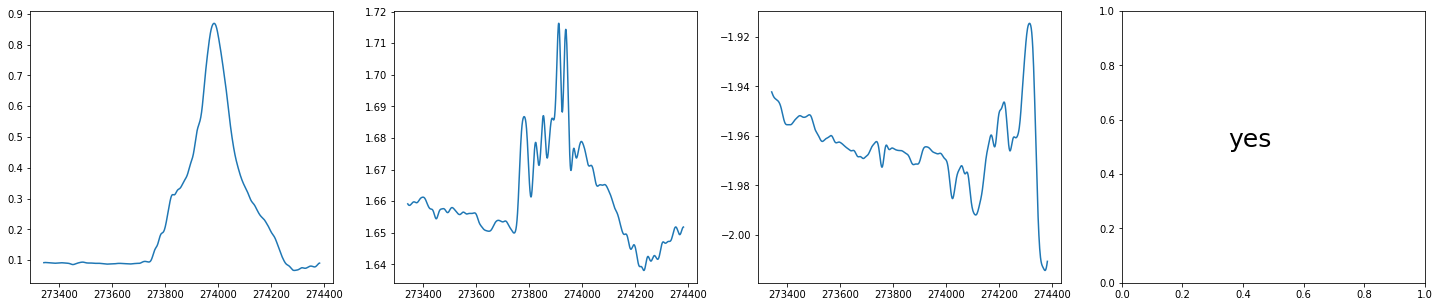

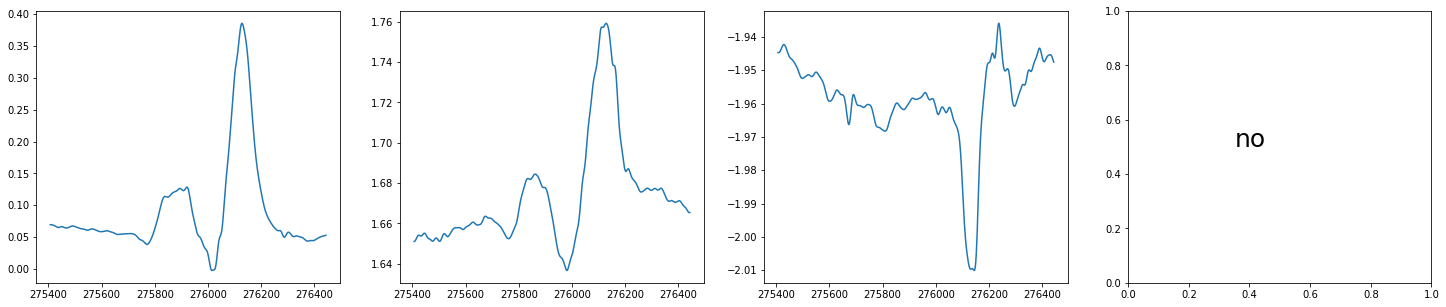

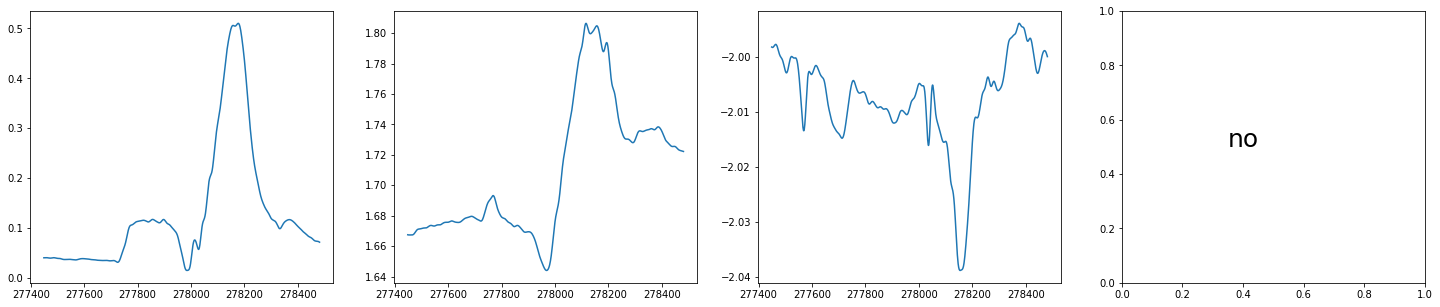

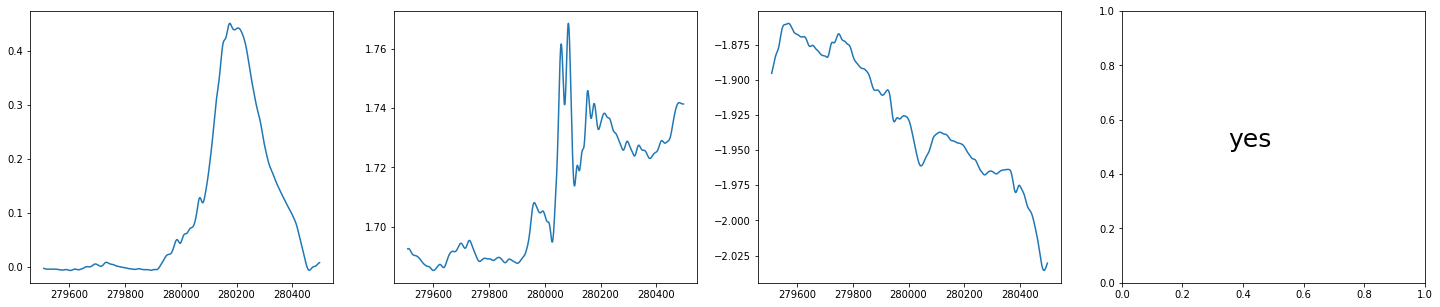

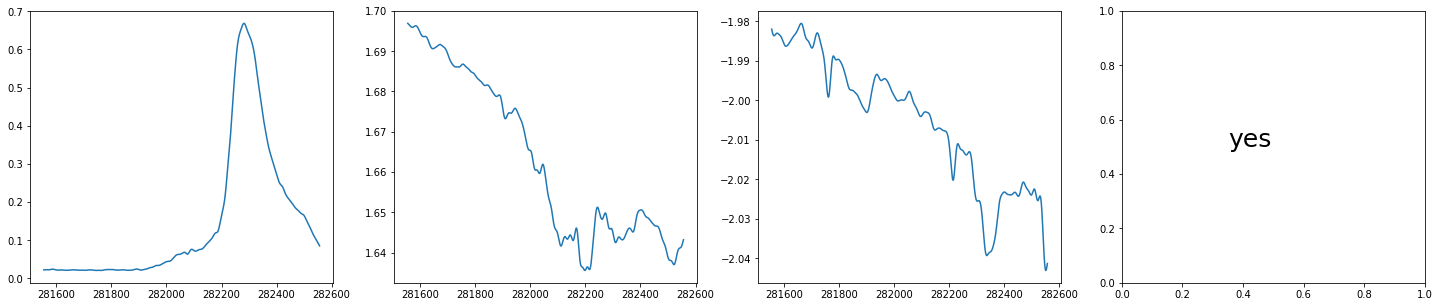

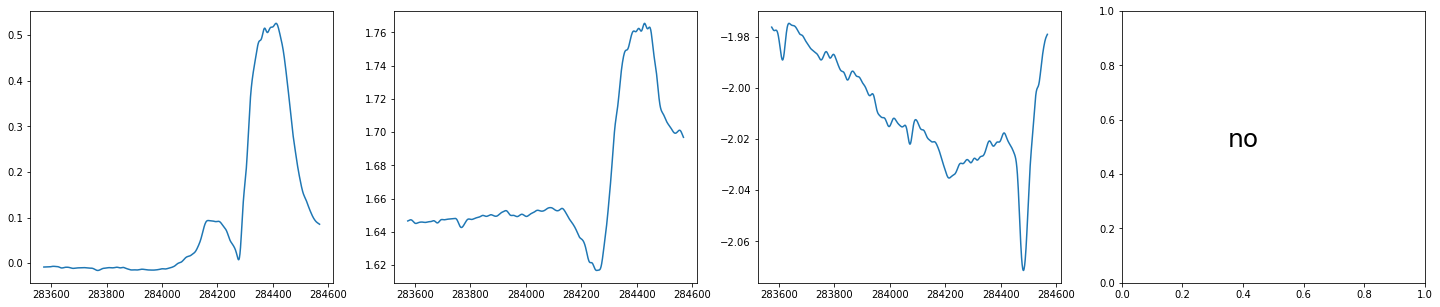

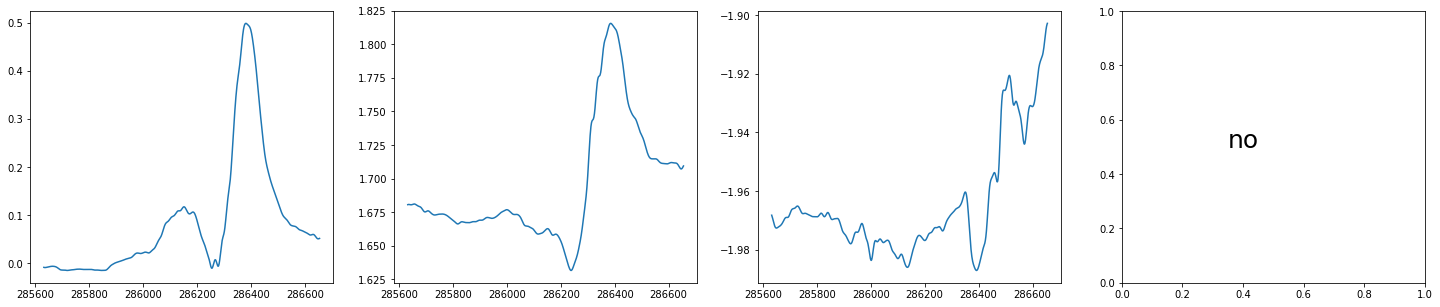

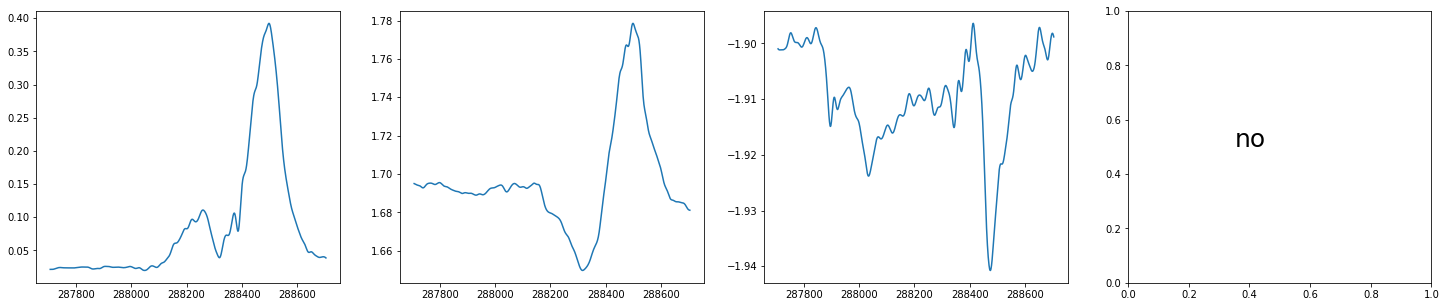

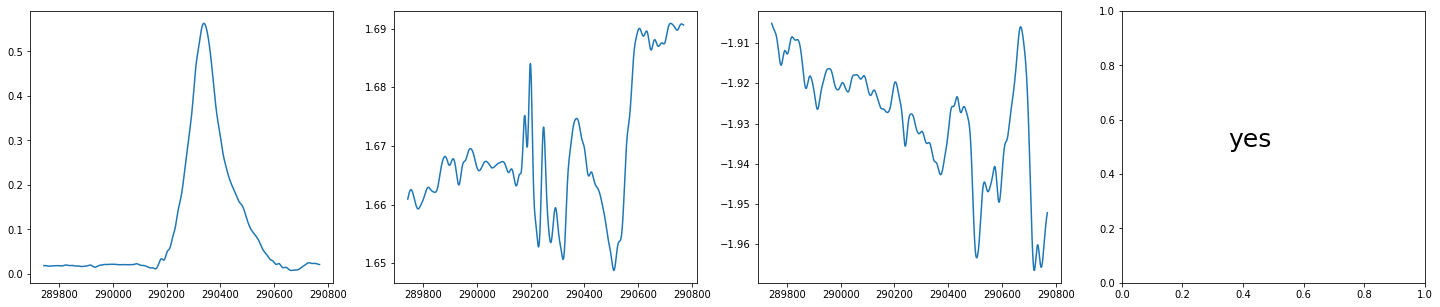

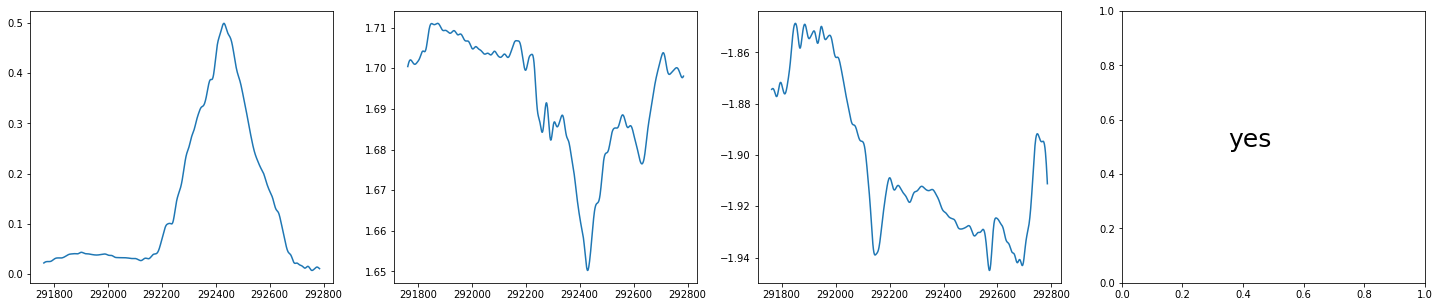

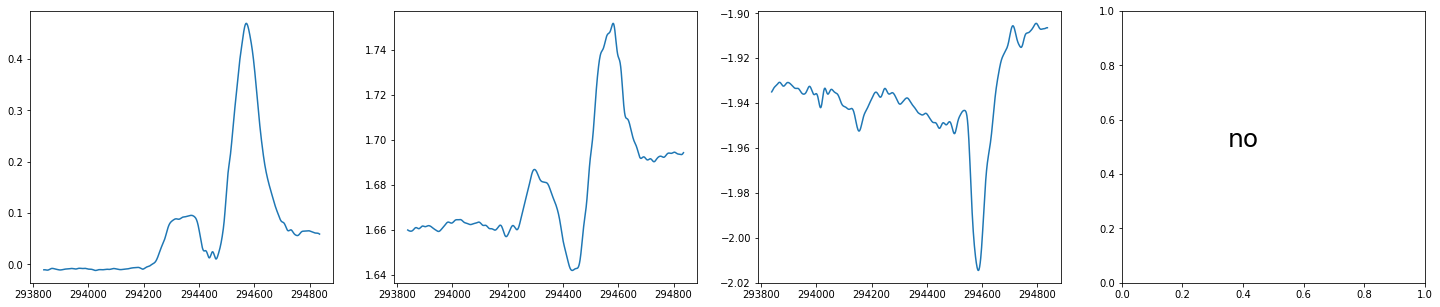

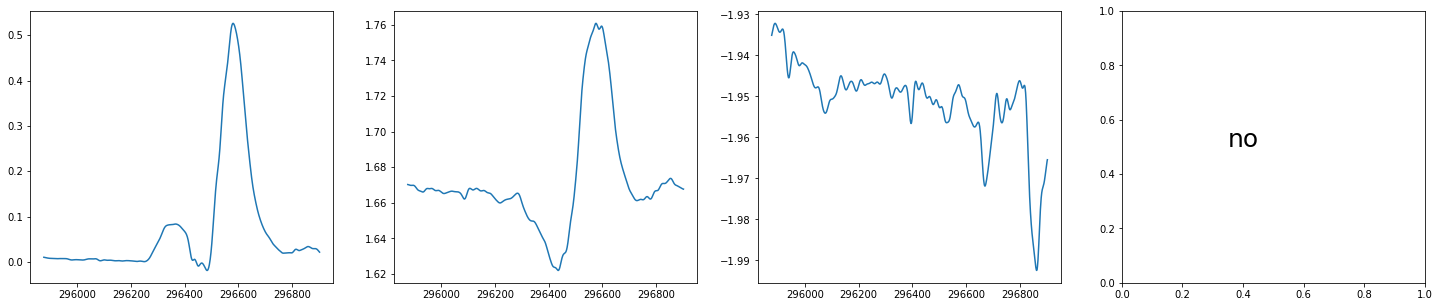

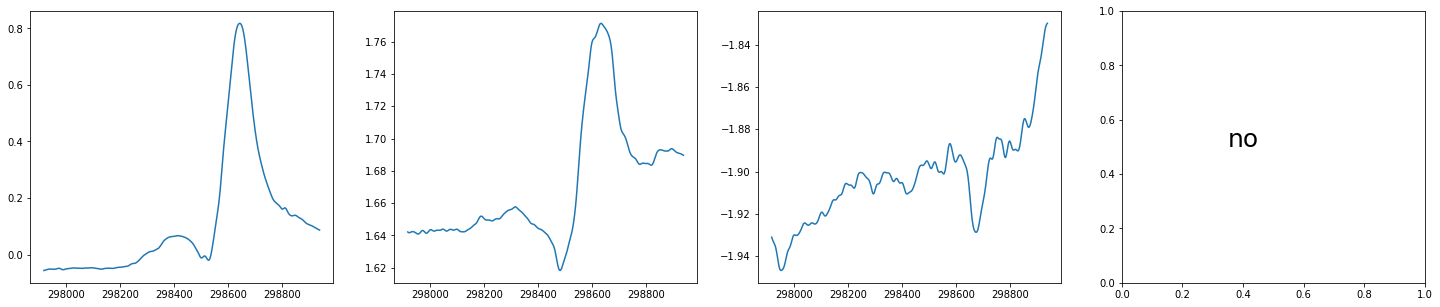

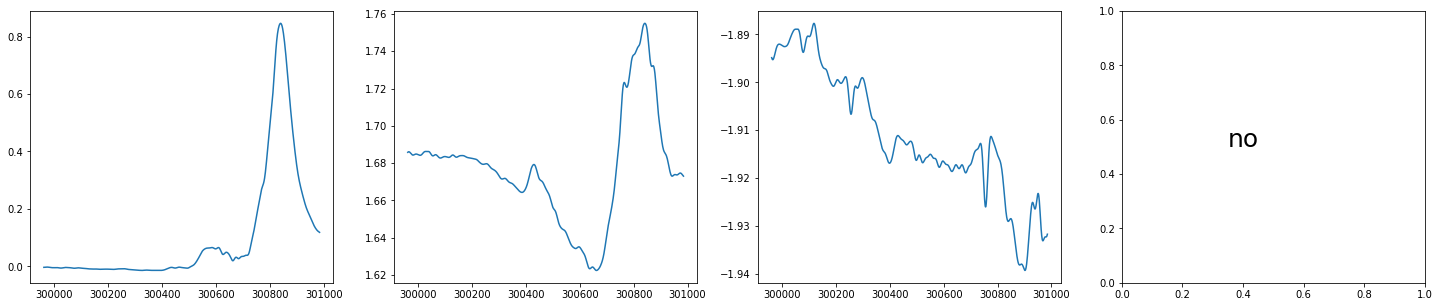

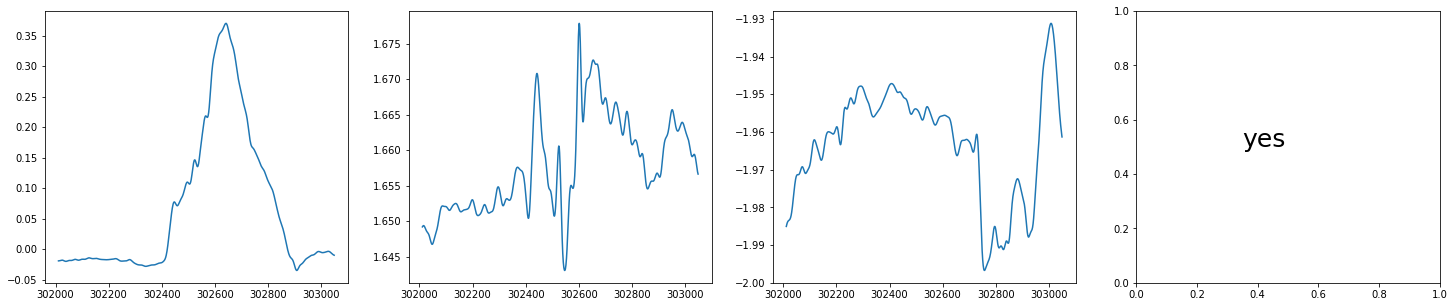

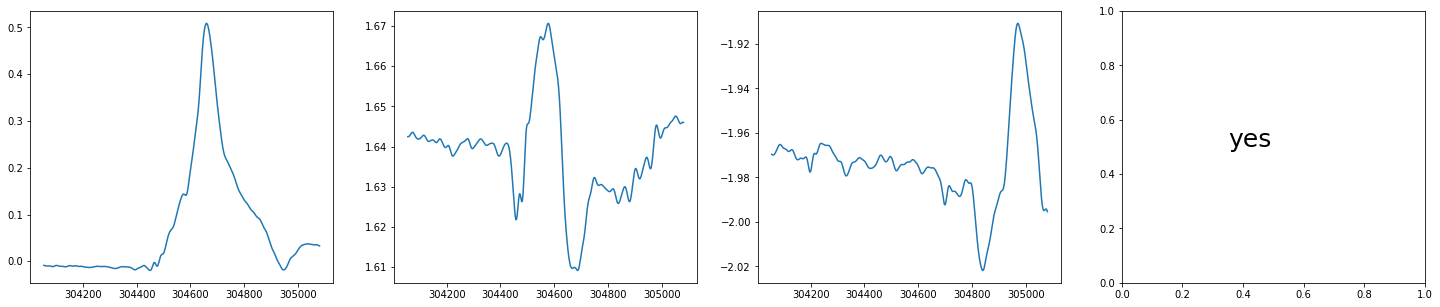

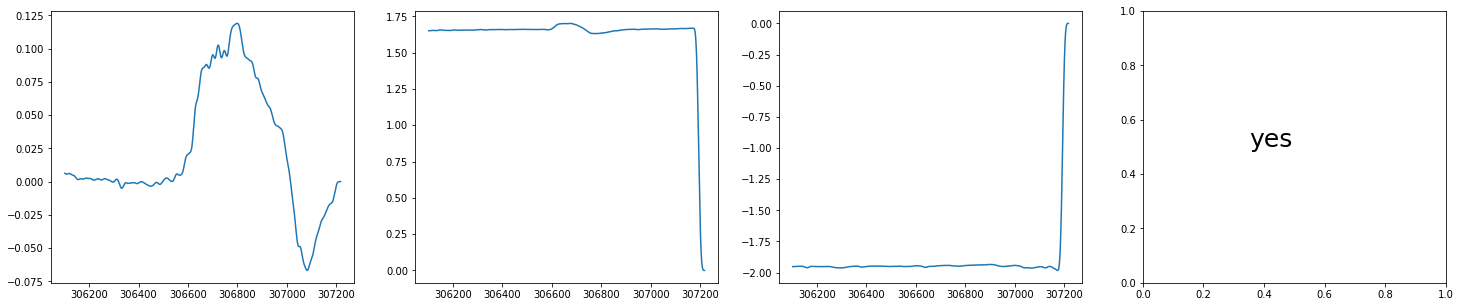

In [11]:
#Plot Results 
for rows in groups:
    create_plots(rows,new_training)

In [22]:
# Find average length of each signal

def max_len(groups):
    avg_len = [(max(val)-min(val)) for val in groups]
    avg = sum(avg_len)/len(avg_len)
    return avg

# Transform Data 

In [13]:
# Transform data with normaizliation 
def trans_data_train(df, val = 'z'):
    for col in df:
        if col not in ['Target']:
            if val == 'z':  
                #take the z-score 
                df[col] = (df[col] - df[col].mean())/df[col].std(ddof=0)
            else:
                #normaizize data between [0,1]
                df[col]=(df[col]-df[col].min())/(df[col].max()-df[col].min())
         
        
def trans_data_test(df_test, df_train, val ='z'):
    for col in df_test:
        if col not in ['Target']:
            if val == 'z':
                #take the z-score 
                df_test[col] = (df_test[col] - df_train[col].mean())/df_train[col].std(ddof=0)
            else:
                #normaizize data between [0,1]
                df_test[col]=(df_test[col]-df_test[col].min())/(df_test[col].max()-df_test[col].min())                                  
                
trans_data_train(new_training,'n')
trans_data_test(new_test, new_training,'n')

In [14]:
# Transform Target column to intergers 

def new_cat_word(row):
    if row == 'relax':
        return 99
    if row == 'no':
        return 0
    else:
        return 1
    
def new_cat_num(row):
    if row == 'relax':
        return 99
    if row == '1':
        return 1
    if row == '2':
        return 2
    if row == '3':
        return 3
    if row == '4':
        return 4
    if row == '5':
        return 5
    if row == '6':
        return 6
    if row == '7':
        return 7
    if row == '8':
        return 8
    if row == '9':
        return 9
    if row == '0':
        return 0

def target_col(val='num'):
    if val == 'num':
        new_test['Target'] = new_test['Target'].apply(new_cat_num)
        new_training['Target'] = new_training['Target'].apply(new_cat_num)
    else:
        new_test['Target'] = new_test['Target'].apply(new_cat_word)
        new_training['Target'] = new_training['Target'].apply(new_cat_word)

target_col(data_type)

In [15]:
#new_training = new_training.iloc[:,0:2]
X_train = [new_training[['CH_1_mV', 'CH_2_mV', 'CH_3_mV']].loc[min(val):max(val)].values for val in groups]
y_train = [new_training[['Target']].loc[min(val):max(val)].values for val in groups]
X_test = [new_test[['CH_1_mV', 'CH_2_mV','CH_3_mV']].loc[min(val):max(val)].values for val in groups]
y_test = [new_test[['Target']].loc[min(val):max(val)].values for val in groups]

In [16]:
len(y_train[3])

1024

# Model Data 

In [17]:
from keras.preprocessing import sequence
import tensorflow as tf

max_length = round_up_to_even(max_len(groups))

X_train = sequence.pad_sequences(X_train, dtype ='float32', maxlen = max_length, padding = 'post', truncating = 'post')
y_train = sequence.pad_sequences(y_train, dtype ='float32', maxlen = max_length, padding = 'post', truncating = 'post')
X_test = sequence.pad_sequences(X_test, dtype ='float32', maxlen = max_length, padding = 'post', truncating = 'post')
y_test = sequence.pad_sequences(y_test, dtype ='float32', maxlen = max_length, padding = 'post', truncating = 'post')

/home/rommeltf/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [18]:
y_train.shape

(150, 1026, 1)

In [ ]:
from keras.layers import LSTM
from keras import optimizers
from keras import layers
from keras import models


model = models.Sequential()
model.add(LSTM(3, input_shape = (max_length, X_train.shape[-1]), return_sequences=True))
model.add(LSTM(3, return_sequences = True))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=.0001),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(X_train, y_train, epochs=10, batch_size=100, validation_split=0.10)

Train on 135 samples, validate on 15 samples
Epoch 1/10
135/135 [==============================] - 11s 79ms/step - loss: 0.6920 - acc: 0.5413 - val_loss: 0.6919 - val_acc: 0.5356
Epoch 2/10
